# Pylops - acoustic wavefield separation with synthetically created data

### Author: M.Ravasi

This is the companion notebook of ``WavefieldSeparation`` notebook. Here to test the routines the input data is created using the modelling operator from synthetically generated up and downgoing fields.

This notebooks is organized as follow:

1. 2D analytical wavefield separation using PyLops chained operators
2. 2D wavefield separation by inversion
3. 2D analytical wavefield separation with irregularly and sparsely sampled x and sparsity promoting inversion
4. 3D analytical wavefield separation by inversion
5. 3D analytical wavefield separation with irregularly and sparsely sampled x and y and sparsity promoting inversion (TO BE DONE..)

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

from scipy.sparse import csr_matrix, vstack
from scipy.signal import filtfilt
from scipy.linalg import lstsq, solve
from scipy.sparse.linalg import LinearOperator, cg, lsqr
from scipy import misc

from pylops.utils                      import dottest
from pylops.utils.wavelets             import *
from pylops.utils.seismicevents        import *
from pylops.basicoperators             import *
from pylops.signalprocessing           import *
from pylops.waveeqprocessing.wavedecomposition import *

from pylops.optimization.leastsquares  import *
from pylops.optimization.sparsity  import *

# 2D

Let's import create a synthetic input data

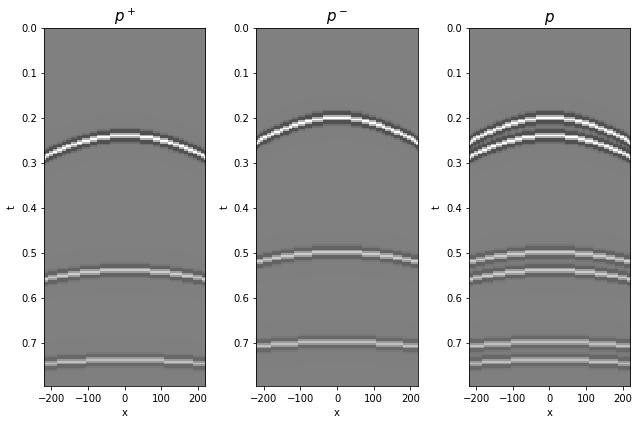

In [2]:
###### Input parameters
par = {'ox':-220,  'dx':5,    'nx':89,
       'oy':-300,  'dy':5,    'ny':121,
       'ot':0,     'dt':0.004, 'nt':200,
       'f0': 40}

t0_minus = np.array([0.2,0.5,0.7])
t0_plus = t0_minus + 0.04
vrms = np.array([1400.,1500., 2000.])
amp = np.array([1.,0.6,0.5])
vel_sep = 900.0 # velocity at separation level
rho_sep = 1000.0 # density at separation level

# Create axis
t,t2,x,y = makeaxis(par)

# Create wavelet
wav = ricker(t[:41], f0=par['f0'])[0]

# Create data
_, p_minus = hyperbolic2d(x, t, t0_minus, vrms, amp, wav)
_, p_plus = hyperbolic2d(x, t, t0_plus, vrms, amp, wav)
p = p_plus + p_minus

plt.figure(figsize=(9,6))
plt.subplot(131)
plt.imshow(p_plus.T,aspect='auto',interpolation='nearest', cmap='gray',
           extent=(x.min(),x.max(),t.max(),t.min()), vmin=-1, vmax=1)
plt.title(r'$p^+$', fontsize=15)
plt.xlabel('x'),plt.ylabel('t')

plt.subplot(132)
plt.imshow(p_minus.T,aspect='auto',interpolation='nearest', cmap='gray',
           extent=(x.min(),x.max(),t.max(),t.min()), vmin=-1, vmax=1)
plt.title(r'$p^-$', fontsize=15)
plt.xlabel('x'),plt.ylabel('t')
plt.tight_layout()

plt.subplot(133)
plt.imshow(p.T,aspect='auto',interpolation='nearest', cmap='gray',
           extent=(x.min(),x.max(),t.max(),t.min()), vmin=-1, vmax=1)
plt.title(r'$p$', fontsize=15)
plt.xlabel('x'),plt.ylabel('t')
plt.tight_layout()

Create frequency-wavenumber spectra (using PyLops FFT2D)

In [3]:
nfft=2**11
FFTop = FFT2D(dims=[par['nx'], par['nt']], nffts=[nfft, nfft], sampling=[par['dx'], par['dt']])
dottest(FFTop, nfft*nfft, par['nt']*par['nx'], complexflag=2)

P = FFTop*p.flatten()
P = P.reshape(nfft, nfft)

## 0. Wavefield composition

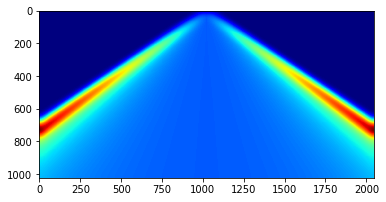

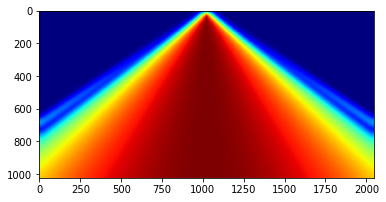

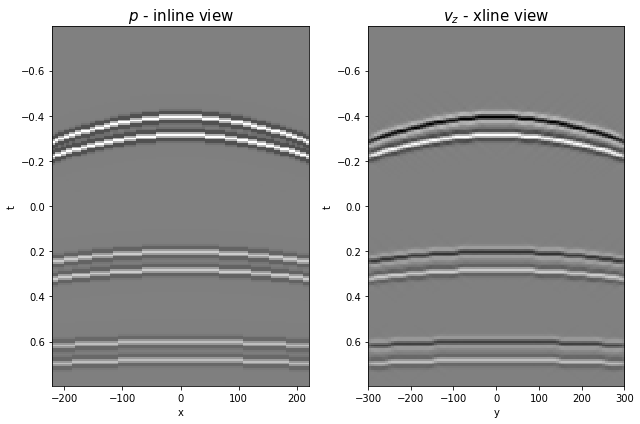

In [4]:
critical = 1.1
ntaper = 51

#obliquity factor
[Kx, F] = np.meshgrid(FFTop.f1, FFTop.f2, indexing='ij')
k=F/vel_sep
#Kz=np.sqrt(k**2-Kx**2)
Kz=np.sqrt((k**2-Kx**2).astype(np.complex))
Kz[np.isnan(Kz)] = 0

OBL=rho_sep*(np.abs(F)/Kz)
OBL[Kz==0]=0

# cut off and taper
mask = np.abs(Kx)<critical*np.abs(F)/vel_sep
OBL = OBL*mask
OBL = filtfilt(np.ones(ntaper)/float(ntaper), 1, OBL, axis=0)
OBL = filtfilt(np.ones(ntaper)/float(ntaper), 1, OBL, axis=1)

OBL1 = Kz /(rho_sep*np.abs(F))
OBL1[F==0] = 0
OBL1 = OBL1*mask
OBL1 = filtfilt(np.ones(ntaper)/float(ntaper), 1, OBL1, axis=0)
OBL1 = filtfilt(np.ones(ntaper)/float(ntaper), 1, OBL1, axis=1)

plt.figure()
plt.imshow(np.fft.fftshift(np.abs(OBL[:, :nfft//2-1]),axes=0).T, cmap='jet')   
plt.figure()
plt.imshow(np.fft.fftshift(np.abs(OBL1[:, :nfft//2-1]),axes=0).T, cmap='jet')   


OBLop = Diagonal(OBL1.flatten(), dtype='complex128')

# wavefield modelling
S1op = (BlockDiag([FFTop.H, FFTop.H])*\
        Block([[Identity(nfft*nfft, dtype='complex128'), Identity(nfft*nfft, dtype='complex128')],
               [OBLop, -OBLop]])*\
        BlockDiag([FFTop, FFTop]))
dottest(S1op, 2*par['nt']*par['nx'], 2*par['nt']*par['nx'], tol=1e-4)

p_sep = np.concatenate((p_plus.flatten(), p_minus.flatten()))
d = S1op * p_sep.flatten()
d = np.real(d.reshape(2*par['nx'], par['nt']))
p, vz = d[:par['nx']], d[par['nx']:]

plt.figure(figsize=(9,6))
plt.subplot(121)
plt.imshow(p.T, aspect='auto',interpolation='nearest', cmap='gray',
           extent=(x.min(),x.max(),t2.max(),t2.min()), vmin=-1, vmax=1)
plt.title(r'$p$ - inline view', fontsize=15)
plt.xlabel('x'),plt.ylabel('t')
plt.subplot(122)
plt.imshow(vz.T, aspect='auto',interpolation='nearest', cmap='gray',
           extent=(y.min(),y.max(),t2.max(),t2.min()))
plt.title(r'$v_z$ - xline view', fontsize=15)
plt.xlabel('y'),plt.ylabel('t')
plt.tight_layout()

And now we recreate the operator but make sure to precondition it such that p and vz are in the same range

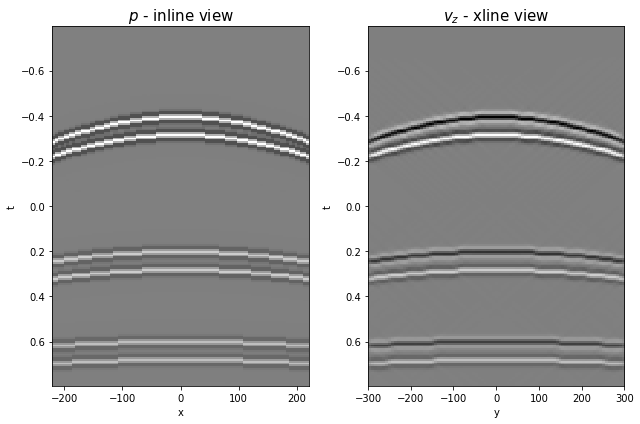

In [5]:
S1op_scaled = (BlockDiag([FFTop.H, (1./vz.max())*FFTop.H])*\
        Block([[Identity(nfft*nfft, dtype='complex128'), Identity(nfft*nfft, dtype='complex128')],
               [OBLop, -OBLop]])*\
        BlockDiag([FFTop, FFTop]))

d_scaled = S1op_scaled * p_sep.flatten()
d_scaled = np.real(d_scaled.reshape(2*par['nx'], par['nt']))
p, vz_scaled = d_scaled[:par['nx']], d_scaled[par['nx']:]

plt.figure(figsize=(9,6))
plt.subplot(121)
plt.imshow(p.T, aspect='auto',interpolation='nearest', cmap='gray',
           extent=(x.min(),x.max(),t2.max(),t2.min()), vmin=-1, vmax=1)
plt.title(r'$p$ - inline view', fontsize=15)
plt.xlabel('x'),plt.ylabel('t')
plt.subplot(122)
plt.imshow(vz_scaled.T, aspect='auto',interpolation='nearest', cmap='gray',
           extent=(y.min(),y.max(),t2.max(),t2.min()), vmin=-1, vmax=1)
plt.title(r'$v_z$ - xline view', fontsize=15)
plt.xlabel('y'),plt.ylabel('t')
plt.tight_layout()

## 1. Analytical wavefield separation

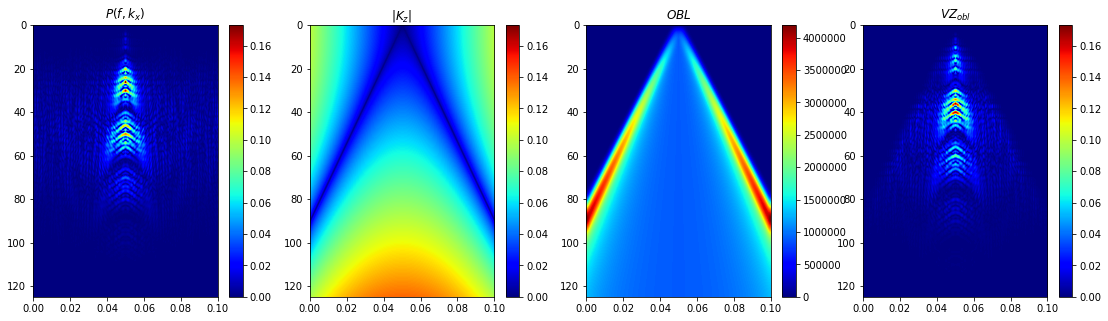

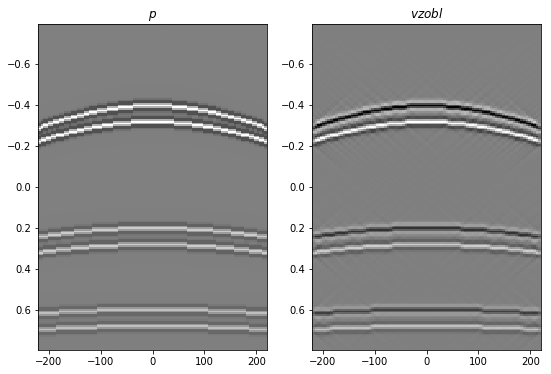

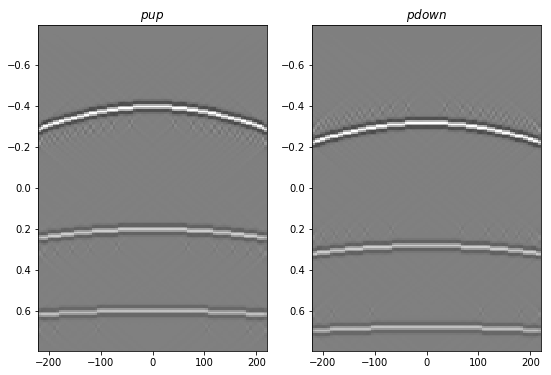

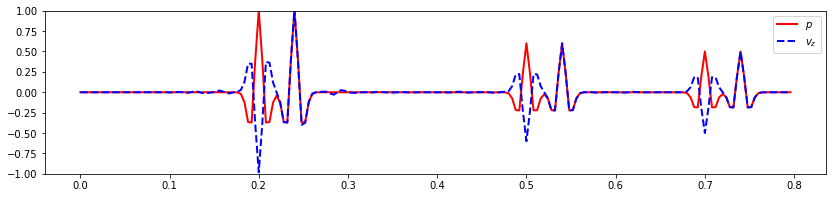

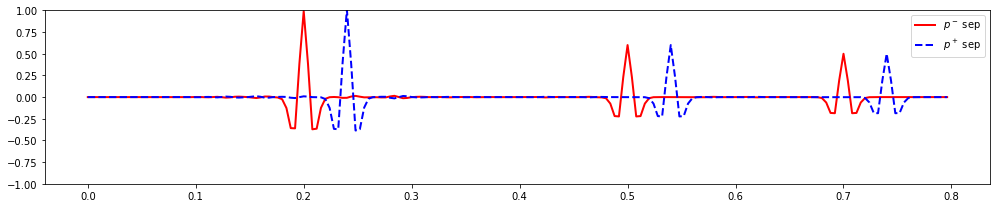

In [6]:
VZ = FFTop*vz.flatten()
VZ = VZ.reshape(nfft, nfft)

# scaled Vz
VZ_obl = OBL*VZ;
vz_obl = FFTop.H*VZ_obl.flatten()
vz_obl = np.real(vz_obl.reshape(par['nx'], par['nt']))

p = FFTop.H*P.flatten()
p = np.real(p.reshape(par['nx'], par['nt']))

# separation
pup_sep=(p-vz_obl)/2;
pdown_sep=(p+vz_obl)/2;


fig, axs = plt.subplots(1, 4, figsize=(19,5))
im=axs[0].imshow(np.fft.fftshift(np.abs(P[:, :nfft//2-1]),axes=0).T, cmap='jet', interpolation='sinc',
             extent = (FFTop.f1[0], FFTop.f1[nfft//2-1], FFTop.f2[nfft//2-1], FFTop.f2[0]),
             vmin=0, vmax=np.abs(P).max())
axs[0].set_title(r'$P(f, k_x)$')
axs[0].axis('tight')
plt.colorbar(im, ax=axs[0])
im=axs[1].imshow(np.fft.fftshift(np.abs(Kz[:, :nfft//2-1]),axes=0).T, cmap='jet', interpolation='sinc',
             extent = (FFTop.f1[0], FFTop.f1[nfft//2-1], FFTop.f2[nfft//2-1], FFTop.f2[0]),
             vmin=0, vmax=np.abs(P).max())
axs[1].set_title(r'$|K_z|$')
axs[1].axis('tight')
plt.colorbar(im, ax=axs[1])
im=axs[2].imshow(np.fft.fftshift(np.abs(OBL[:, :nfft//2-1]),axes=0).T, cmap='jet', interpolation='sinc',
                 extent = (FFTop.f1[0], FFTop.f1[nfft//2-1], FFTop.f2[nfft//2-1], FFTop.f2[0]))
axs[2].set_title(r'$OBL$')
axs[2].axis('tight')
plt.colorbar(im, ax=axs[2])
im=axs[3].imshow(np.fft.fftshift(np.abs(VZ_obl[:, :nfft//2-1]),axes=0).T, cmap='jet', interpolation='sinc',
                 extent = (FFTop.f1[0], FFTop.f1[nfft//2-1], FFTop.f2[nfft//2-1], FFTop.f2[0]),
                 vmin=0, vmax=np.abs(P).max())
axs[3].set_title(r'$VZ_{obl}$')
axs[3].axis('tight')
plt.colorbar(im, ax=axs[3])

fig, axs = plt.subplots(1, 2, figsize=(9,6))
axs[0].imshow(p.T, cmap='gray',            
              extent=(x.min(),x.max(),t2.max(),t2.min()), 
              vmin=-1, vmax=1)
axs[0].set_title(r'$p$')
axs[0].axis('tight')
axs[1].imshow(vz_obl.T, cmap='gray',            
              extent=(x.min(),x.max(),t2.max(),t2.min()), 
              vmin=-1, vmax=1)
axs[1].set_title(r'$vzobl$')
axs[1].axis('tight')

fig, axs = plt.subplots(1, 2, figsize=(9,6))
axs[0].imshow(pup_sep.T, cmap='gray',            
              extent=(x.min(),x.max(),t2.max(),t2.min()), 
              vmin=-1, vmax=1)
axs[0].set_title(r'$pup$')
axs[0].axis('tight')
axs[1].imshow(pdown_sep.T, cmap='gray',            
              extent=(x.min(),x.max(),t2.max(),t2.min()), 
              vmin=-1, vmax=1)
axs[1].set_title(r'$pdown$')
axs[1].axis('tight')

plt.figure(figsize=(14, 3))
plt.plot(t, p[par['nx']//2], 'r', lw=2, label=r'$p$')
plt.plot(t, vz_obl[par['nx']//2], '--b', lw=2, label=r'$v_z$')
plt.ylim(-1, 1)
plt.legend()
plt.figure(figsize=(14, 3))
plt.plot(t, pup_sep[par['nx']//2], 'r', lw=2, label=r'$p^-$ sep')
plt.plot(t, pdown_sep[par['nx']//2], '--b', lw=2, label=r'$p^+$ sep')
plt.ylim(-1, 1)
plt.legend()
plt.tight_layout()

Use function

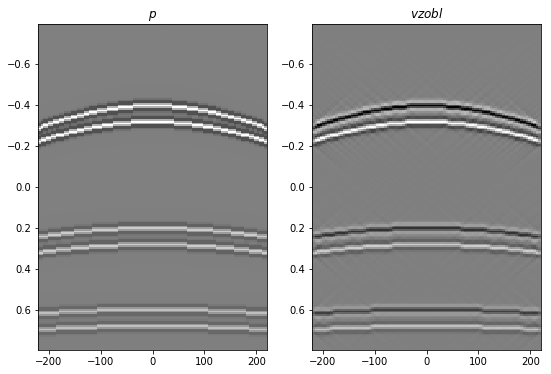

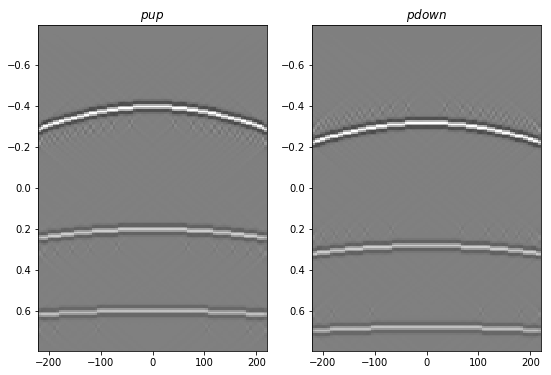

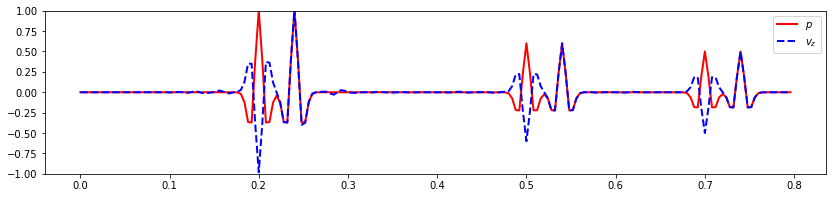

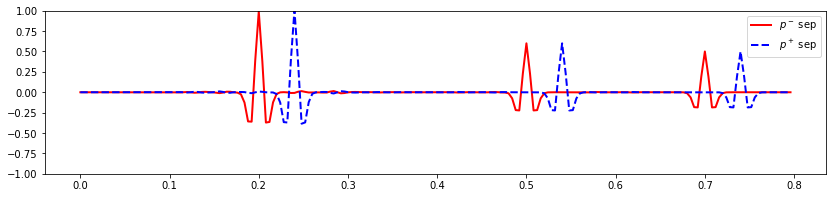

In [7]:
pup_sep, pdown_sep = \
    WavefieldDecomposition(p, vz, par['nt'], par['nx'], par['dt'], par['dx'], 
                           rho_sep, vel_sep, nffts=(nfft, nfft), kind='analytical',
                           critical=critical*100, ntaper=ntaper,
                           dtype='complex128')

fig, axs = plt.subplots(1, 2, figsize=(9,6))
axs[0].imshow(p.T, cmap='gray',            
              extent=(x.min(),x.max(),t2.max(),t2.min()), 
              vmin=-1, vmax=1)
axs[0].set_title(r'$p$')
axs[0].axis('tight')
axs[1].imshow(vz_obl.T, cmap='gray',            
              extent=(x.min(),x.max(),t2.max(),t2.min()), 
              vmin=-1, vmax=1)
axs[1].set_title(r'$vzobl$')
axs[1].axis('tight')

fig, axs = plt.subplots(1, 2, figsize=(9,6))
axs[0].imshow(pup_sep.T, cmap='gray',            
              extent=(x.min(),x.max(),t2.max(),t2.min()), 
              vmin=-1, vmax=1)
axs[0].set_title(r'$pup$')
axs[0].axis('tight')
axs[1].imshow(pdown_sep.T, cmap='gray',            
              extent=(x.min(),x.max(),t2.max(),t2.min()), 
              vmin=-1, vmax=1)
axs[1].set_title(r'$pdown$')
axs[1].axis('tight')

plt.figure(figsize=(14, 3))
plt.plot(t, p[par['nx']//2], 'r', lw=2, label=r'$p$')
plt.plot(t, vz_obl[par['nx']//2], '--b', lw=2, label=r'$v_z$')
plt.ylim(-1, 1)
plt.legend()
plt.figure(figsize=(14, 3))
plt.plot(t, pup_sep[par['nx']//2], 'r', lw=2, label=r'$p^-$ sep')
plt.plot(t, pdown_sep[par['nx']//2], '--b', lw=2, label=r'$p^+$ sep')
plt.ylim(-1, 1)
plt.legend()

## 2. Wavefield separation by inversion

 
LSQR            Least-squares solution of  Ax = b
The matrix A has    35600 rows  and    35600 cols
damp = 1.00000000000000e-10   calc_var =        0
atol = 1.00e-08                 conlim = 1.00e+08
btol = 1.00e-08               iter_lim =       50
 
   Itn      x[0]       r1norm     r2norm   Compatible    LS      Norm A   Cond A
     0  0.00000e+00   3.178e+01  3.178e+01    1.0e+00  4.4e-02
     1 -4.48308e-06   2.143e+00  2.143e+00    6.7e-02  7.9e-01   1.4e+00  1.0e+00
     2 -3.18471e-06   8.784e-01  8.784e-01    2.8e-02  4.4e-01   1.8e+00  2.0e+00
     3 -1.01464e-06   4.920e-01  4.920e-01    1.5e-02  3.2e-01   2.1e+00  3.3e+00
     4 -3.00285e-05   3.249e-01  3.249e-01    1.0e-02  2.6e-01   2.3e+00  4.6e+00
     5 -8.32094e-05   2.346e-01  2.346e-01    7.4e-03  2.2e-01   2.6e+00  6.1e+00
     6 -1.31942e-04   1.774e-01  1.774e-01    5.6e-03  1.8e-01   2.8e+00  7.8e+00
     7 -1.77483e-04   1.402e-01  1.402e-01    4.4e-03  1.6e-01   2.9e+00  9.6e+00
     8 -1.37407e-04   1.153e

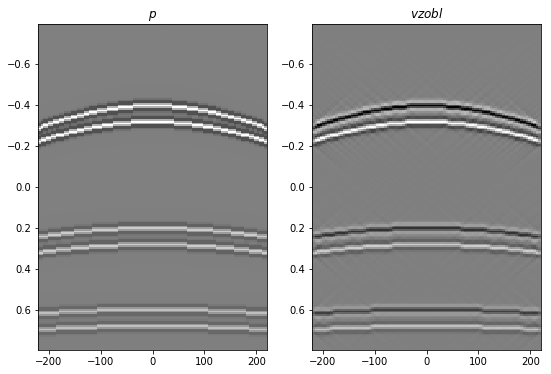

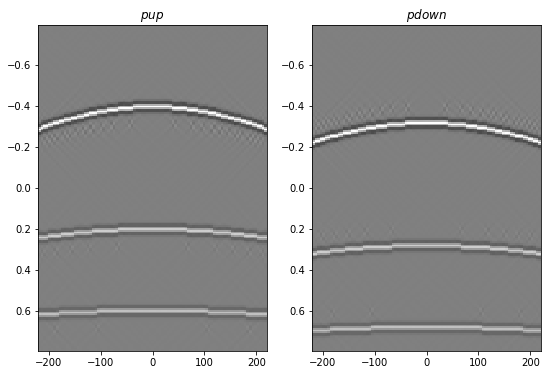

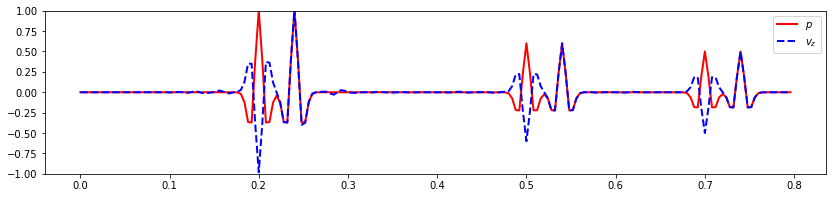

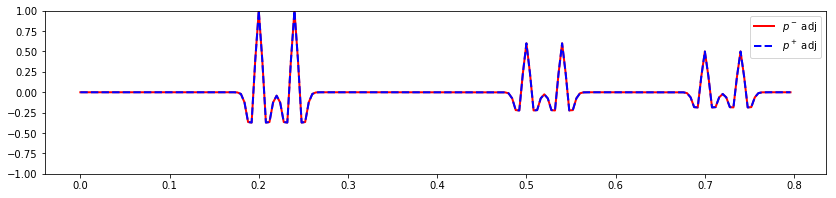

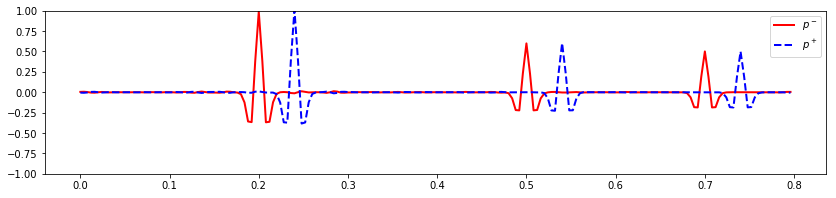

In [8]:
# adjoint and inverse
dud_adj = np.real(S1op_scaled.H * d.flatten())
dud_inv, istop, itn, r1norm, r2norm = lsqr(S1op_scaled, d_scaled.flatten(), 
                                           damp=1e-10, iter_lim=50, show=2)[0:5]
dud_inv = np.real(dud_inv)

dud_adj = dud_adj.reshape(2*par['nx'], par['nt'])
dud_inv = dud_inv.reshape(2*par['nx'], par['nt'])

pdown_adj, pup_adj= dud_adj[:par['nx']], dud_adj[par['nx']:]
pdown_inv, pup_inv= dud_inv[:par['nx']], dud_inv[par['nx']:]

fig, axs = plt.subplots(1, 2, figsize=(9,6))
axs[0].imshow(p.T, cmap='gray', vmin=-np.abs(p).max(), vmax=np.abs(p).max(),
              extent = (x.min(),x.max(),t2.max(),t2.min()))
axs[0].set_title(r'$p$')
axs[0].axis('tight')
axs[1].imshow(vz_obl.T, cmap='gray', vmin=-np.abs(p).max(), vmax=np.abs(p).max(),
              extent = (x.min(),x.max(),t2.max(),t2.min()))
axs[1].set_title(r'$vzobl$')
axs[1].axis('tight')

fig, axs = plt.subplots(1, 2, figsize=(9,6))
axs[0].imshow(pup_inv.T, cmap='gray', vmin=-np.abs(p).max(), vmax=np.abs(p).max(),
              extent = (x.min(),x.max(),t2.max(),t2.min()))
axs[0].set_title(r'$pup$')
axs[0].axis('tight')
axs[1].imshow(pdown_inv.T, cmap='gray', vmin=-np.abs(p).max(), vmax=np.abs(p).max(),
              extent = (x.min(),x.max(),t2.max(),t2.min()))
axs[1].set_title(r'$pdown$')
axs[1].axis('tight')

plt.figure(figsize=(14, 3))
plt.plot(t, p[par['nx']//2], 'r', lw=2, label=r'$p$')
plt.plot(t, vz_obl[par['nx']//2], '--b', lw=2, label=r'$v_z$')
plt.ylim(-1, 1)
plt.legend()
plt.figure(figsize=(14, 3))
plt.plot(t, pup_adj[par['nx']//2], 'r', lw=2, label=r'$p^-$ adj')
plt.plot(t, pdown_adj[par['nx']//2], '--b', lw=2, label=r'$p^+$ adj')
plt.ylim(-1, 1)
plt.legend()
plt.figure(figsize=(14, 3))
plt.plot(t, pup_inv[par['nx']//2], 'r', lw=2, label=r'$p^-$')
plt.plot(t, pdown_inv[par['nx']//2], '--b', lw=2, label=r'$p^+$')
plt.ylim(-1, 1)
plt.legend();

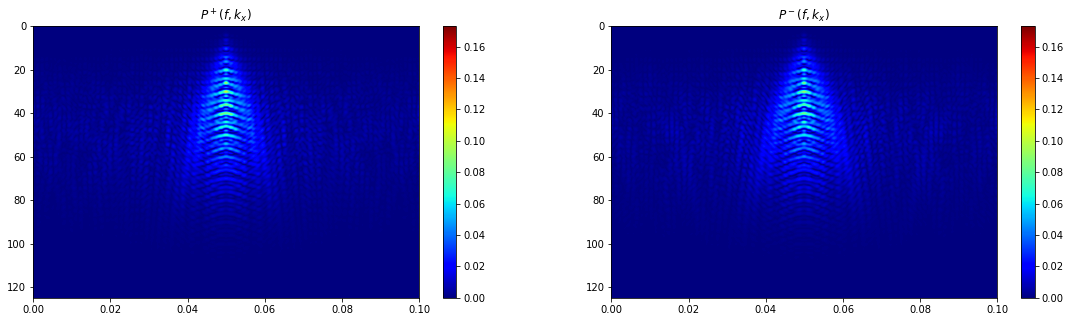

In [9]:
PUP_inv = (FFTop*pup_inv.flatten()).reshape(nfft, nfft)
PDOWN_inv = (FFTop*pdown_inv.flatten()).reshape(nfft, nfft)

fig, axs = plt.subplots(1, 2, figsize=(19,5))
im=axs[0].imshow(np.fft.fftshift(np.abs(PDOWN_inv[:, :nfft//2-1]),axes=0).T, 
                 cmap='jet', interpolation='sinc',
                 extent = (FFTop.f1[0], FFTop.f1[nfft//2-1], FFTop.f2[nfft//2-1], FFTop.f2[0]),
                 vmin=0, vmax=np.abs(P).max())
axs[0].set_title(r'$P^+(f, k_x)$')
axs[0].axis('tight')
plt.colorbar(im, ax=axs[0])
im=axs[1].imshow(np.fft.fftshift(np.abs(PUP_inv[:, :nfft//2-1]),axes=0).T,
                 cmap='jet', interpolation='sinc',
                 extent = (FFTop.f1[0], FFTop.f1[nfft//2-1], FFTop.f2[nfft//2-1], FFTop.f2[0]),
                 vmin=0, vmax=np.abs(P).max())
axs[0].set_title(r'$P^+(f, k_x)$')
axs[1].set_title(r'$P^-(f, k_x)$')
axs[1].axis('tight')
plt.colorbar(im, ax=axs[1]);

Use function

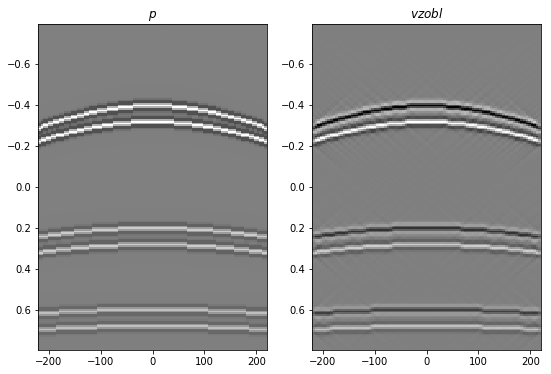

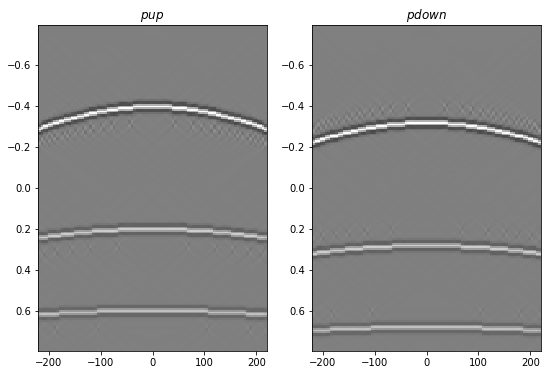

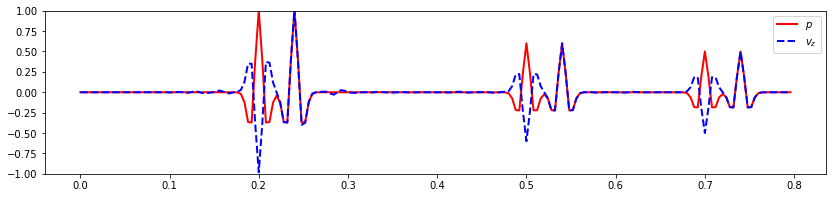

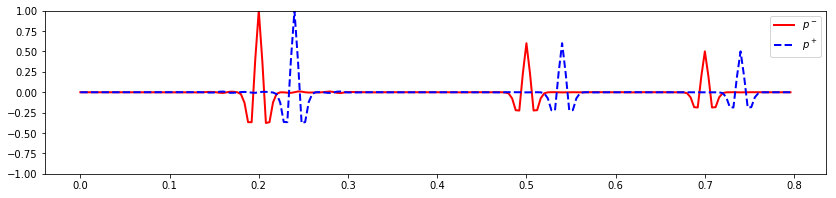

In [10]:
pup_inv, pdown_inv = WavefieldDecomposition(p, vz, par['nt'], par['nx'], par['dt'], par['dx'], 
                                            rho_sep, vel_sep, nffts=(nfft, nfft), kind='inverse',
                                            critical=critical*100, ntaper=ntaper,
                                            dtype='complex128')

fig, axs = plt.subplots(1, 2, figsize=(9,6))
axs[0].imshow(p.T, cmap='gray', vmin=-np.abs(p).max(), vmax=np.abs(p).max(),
              extent = (x.min(),x.max(),t2.max(),t2.min()))
axs[0].set_title(r'$p$')
axs[0].axis('tight')
axs[1].imshow(vz_obl.T, cmap='gray', vmin=-np.abs(p).max(), vmax=np.abs(p).max(),
              extent = (x.min(),x.max(),t2.max(),t2.min()))
axs[1].set_title(r'$vzobl$')
#axs[1].plot(r[0], direct, 'r', lw=1)
axs[1].axis('tight')

fig, axs = plt.subplots(1, 2, figsize=(9,6))
axs[0].imshow(pup_inv.T, cmap='gray', vmin=-np.abs(p).max(), vmax=np.abs(p).max(),
              extent = (x.min(),x.max(),t2.max(),t2.min()))
axs[0].set_title(r'$pup$')
axs[0].axis('tight')
axs[1].imshow(pdown_inv.T, cmap='gray', vmin=-np.abs(p).max(), vmax=np.abs(p).max(),
              extent = (x.min(),x.max(),t2.max(),t2.min()))
axs[1].set_title(r'$pdown$')
axs[1].axis('tight')

plt.figure(figsize=(14, 3))
plt.plot(t, p[par['nx']//2], 'r', lw=2, label=r'$p$')
plt.plot(t, vz_obl[par['nx']//2], '--b', lw=2, label=r'$v_z$')
plt.ylim(-1, 1)
plt.legend()

plt.figure(figsize=(14, 3))
plt.plot(t, pup_inv[par['nx']//2], 'r', lw=2, label=r'$p^-$')
plt.plot(t, pdown_inv[par['nx']//2], '--b', lw=2, label=r'$p^+$')
plt.ylim(-1, 1)
plt.legend();

## 3. Wavefield separation by inversion with sparsity (model in local linear radon domain)

We start without performing any subsampling of input wavefields

In [11]:
dx = par['dx']
nwin=21
nwins=5
nover=5
npx=101
pxmax = 5e-4
px = np.linspace(-pxmax, pxmax, npx)
dimsd = p_plus.shape
dims = (nwins*npx, dimsd[1])

# sliding window radon with overlap
Op = Radon2D(t, np.linspace(-dx*nwin//2, dx*nwin//2, nwin), px, centeredh=True,
             kind='linear', engine='numba')
Slidop = Sliding2D(Op, dims, dimsd, nwin, nover, tapertype='cosine', design=True)
dottest(Slidop, np.prod(dimsd), np.prod(dims))

True

Now we also subsample the data

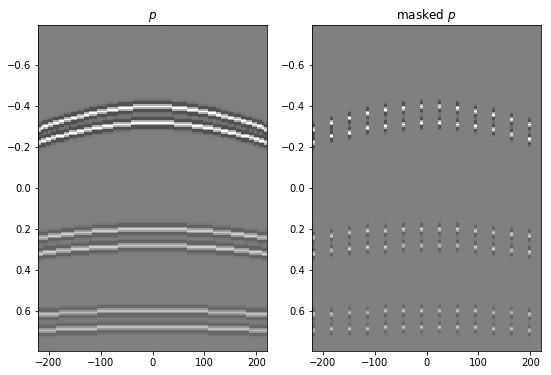

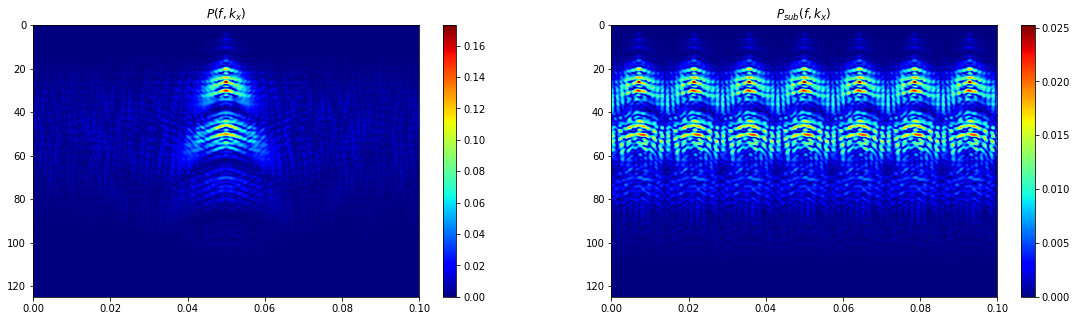

In [12]:
# subsampling locations
#perc_subsampling = 0.6
#Nsub = int(np.round(par['nx']*perc_subsampling))
#iava = np.sort(np.random.permutation(np.arange(par['nx']))[:Nsub])
iava = np.arange(0, par['nx'], 7)
Nsub= len(iava)

Rop = Restriction(par['nx']*par['nt'], iava, 
                  dims=(par['nx'], par['nt']), 
                  dir=0, dtype='float64')
Rop = BlockDiag([Rop, Rop])
d_subsampled = Rop*d_scaled.flatten()
d_subsampled_adj = Rop.H*d_subsampled.flatten()

d_subsampled = d_subsampled.reshape(2*Nsub, par['nt'])
d_subsampled_adj = d_subsampled_adj.reshape(2*par['nx'], par['nt'])

p_subsampled, vz_subsampled = d_subsampled[:Nsub], d_subsampled[Nsub:]
p_subsampled_adj, vz_subsampled_adj= d_subsampled_adj[:par['nx']], d_subsampled_adj[par['nx']:]


fig, axs = plt.subplots(1, 2, figsize=(9,6))
axs[0].imshow(p.T, cmap='gray', vmin=-np.abs(p).max(), vmax=np.abs(p).max(),
              extent = (x.min(),x.max(),t2.max(),t2.min()))
axs[0].set_title(r'$p$')
axs[0].axis('tight')
axs[1].imshow(p_subsampled_adj.T, cmap='gray', vmin=-np.abs(p).max(), vmax=np.abs(p).max(),
              extent = (x.min(),x.max(),t2.max(),t2.min()))
axs[1].set_title(r'masked $p$')
axs[1].axis('tight')

P = (FFTop*p.flatten()).reshape(nfft, nfft)
PSUB = (FFTop*p_subsampled_adj.flatten()).reshape(nfft, nfft)


fig, axs = plt.subplots(1, 2, figsize=(19,5))
im=axs[0].imshow(np.fft.fftshift(np.abs(P[:, :nfft//2-1]),axes=0).T, 
                 cmap='jet', interpolation='sinc',
                 extent = (FFTop.f1[0], FFTop.f1[nfft//2-1], FFTop.f2[nfft//2-1], FFTop.f2[0]),
                 vmin=0, vmax=np.abs(P).max())
axs[0].set_title(r'$P(f, k_x)$')
axs[0].axis('tight')
plt.colorbar(im, ax=axs[0])
im=axs[1].imshow(np.fft.fftshift(np.abs(PSUB[:, :nfft//2-1]),axes=0).T,
                 cmap='jet', interpolation='sinc',
                 extent = (FFTop.f1[0], FFTop.f1[nfft//2-1], FFTop.f2[nfft//2-1], FFTop.f2[0]),
                 vmin=0, vmax=np.abs(PSUB).max())
axs[1].set_title(r'$P_{sub}(f, k_x)$')
axs[1].axis('tight')
plt.colorbar(im, ax=axs[1]);

 
LSQR            Least-squares solution of  Ax = b
The matrix A has     5200 rows  and   202000 cols
damp = 1.00000000000000e-10   calc_var =        0
atol = 1.00e-08                 conlim = 1.00e+08
btol = 1.00e-08               iter_lim =       50
 
   Itn      x[0]       r1norm     r2norm   Compatible    LS      Norm A   Cond A
     0  0.00000e+00   1.209e+01  1.209e+01    1.0e+00  1.0e+00
     1 -2.00092e-07   3.657e+00  3.657e+00    3.0e-01  9.6e-01   1.3e+01  1.0e+00
     2  2.35056e-07   1.688e+00  1.688e+00    1.4e-01  7.0e-01   1.9e+01  2.1e+00
     3  1.22725e-07   9.515e-01  9.515e-01    7.9e-02  5.0e-01   2.7e+01  3.4e+00
     4 -2.71579e-07   5.449e-01  5.449e-01    4.5e-02  3.7e-01   3.2e+01  4.7e+00
     5 -1.98150e-07   3.507e-01  3.507e-01    2.9e-02  2.8e-01   3.7e+01  6.1e+00
     6  2.03590e-07   2.685e-01  2.685e-01    2.2e-02  2.0e-01   4.1e+01  7.4e+00
     7  4.38352e-07   2.215e-01  2.215e-01    1.8e-02  1.5e-01   4.4e+01  8.9e+00
     8  4.85076e-07   1.920e

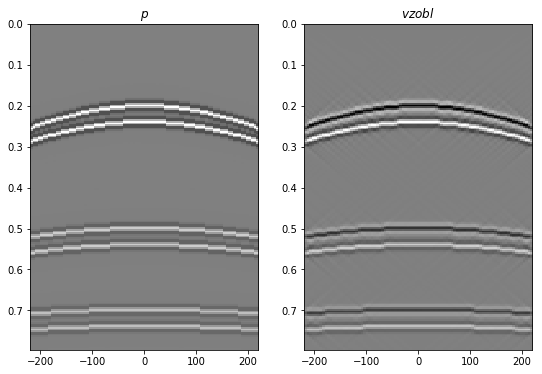

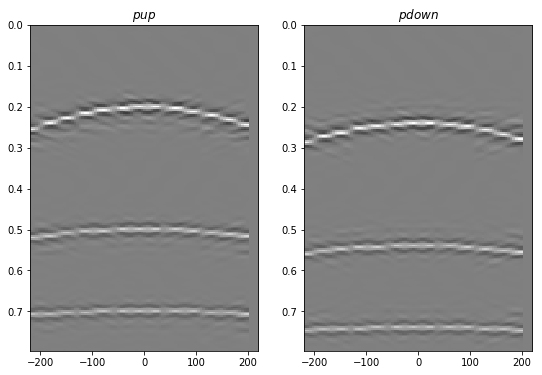

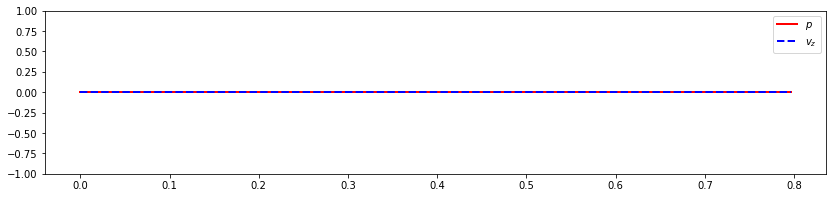

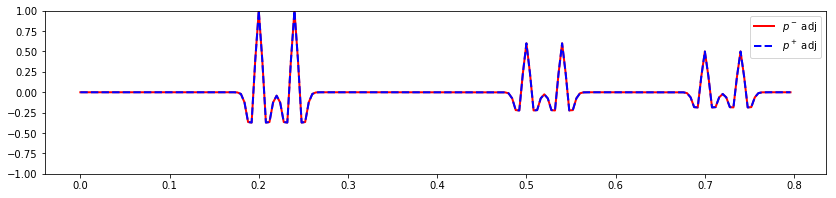

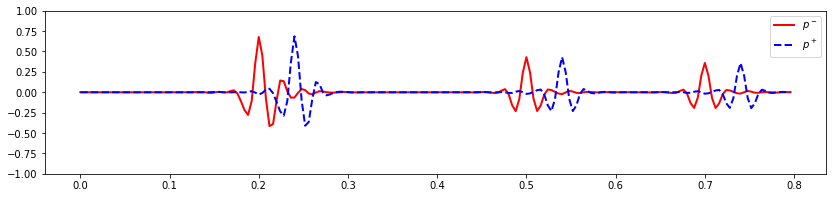

In [13]:
Stot = Rop*S1op_scaled*BlockDiag([Slidop, Slidop])

pwud_adj = Stot.H * d_subsampled.flatten()
pwud_inv, istop, itn, r1norm, r2norm = lsqr(Stot, d_subsampled.flatten(), 
                                            damp=1e-10, iter_lim=50, show=2)[0:5]
dud_inv = BlockDiag([Slidop, Slidop])*np.real(pwud_inv)

pwud_adj = pwud_adj.reshape(2*nwins*npx, par['nt'])
pwud_inv = pwud_inv.reshape(2*nwins*npx, par['nt'])
dud_inv = dud_inv.reshape(2*par['nx'], par['nt'])

pdown_inv, pup_inv = dud_inv[:par['nx']], dud_inv[par['nx']:]

fig, axs = plt.subplots(1, 2, figsize=(9,6))
axs[0].imshow(p.T, cmap='gray', vmin=-np.abs(p).max(), vmax=np.abs(p).max(),
              extent = (x.min(),x.max(),t.max(),t.min()))
axs[0].set_title(r'$p$')
axs[0].axis('tight')
axs[1].imshow(vz_obl.T, cmap='gray', vmin=-np.abs(p).max(), vmax=np.abs(p).max(),
              extent = (x.min(),x.max(),t.max(),t.min()))
axs[1].set_title(r'$vzobl$')
axs[1].axis('tight')

fig, axs = plt.subplots(1, 2, figsize=(9,6))
axs[0].imshow(pup_inv.T, cmap='gray', vmin=-np.abs(p).max(), vmax=np.abs(p).max(),
              extent = (x.min(),x.max(),t.max(),t.min()))
axs[0].set_title(r'$pup$')
axs[0].axis('tight')
axs[1].imshow(pdown_inv.T, cmap='gray', vmin=-np.abs(p).max(), vmax=np.abs(p).max(),
              extent = (x.min(),x.max(),t.max(),t.min()))
axs[1].set_title(r'$pdown$')
axs[1].axis('tight')

plt.figure(figsize=(14, 3))
plt.plot(t, p_subsampled_adj[par['nx']//2], 'r', lw=2, label=r'$p$')
plt.plot(t, vz_subsampled_adj[par['nx']//2], '--b', lw=2, label=r'$v_z$')
plt.ylim(-1, 1)
plt.legend()
plt.figure(figsize=(14, 3))
plt.plot(t, pup_adj[par['nx']//2], 'r', lw=2, label=r'$p^-$ adj')
plt.plot(t, pdown_adj[par['nx']//2], '--b', lw=2, label=r'$p^+$ adj')
plt.ylim(-1, 1)
plt.legend()
plt.figure(figsize=(14, 3))
plt.plot(t, pup_inv[par['nx']//2], 'r', lw=2, label=r'$p^-$')
plt.plot(t, pdown_inv[par['nx']//2], '--b', lw=2, label=r'$p^+$')
plt.ylim(-1, 1)
plt.legend();

Use function

 
LSQR            Least-squares solution of  Ax = b
The matrix A has     5200 rows  and   202000 cols
damp = 1.00000000000000e-10   calc_var =        0
atol = 1.00e-08                 conlim = 1.00e+08
btol = 1.00e-08               iter_lim =       50
 
   Itn      x[0]       r1norm     r2norm   Compatible    LS      Norm A   Cond A
     0  0.00000e+00   1.209e+01  1.209e+01    1.0e+00  1.0e+00
     1 -2.00092e-07   3.657e+00  3.657e+00    3.0e-01  9.6e-01   1.3e+01  1.0e+00
     2  2.35056e-07   1.688e+00  1.688e+00    1.4e-01  7.0e-01   1.9e+01  2.1e+00
     3  1.22725e-07   9.515e-01  9.515e-01    7.9e-02  5.0e-01   2.7e+01  3.4e+00
     4 -2.71579e-07   5.449e-01  5.449e-01    4.5e-02  3.7e-01   3.2e+01  4.7e+00
     5 -1.98150e-07   3.507e-01  3.507e-01    2.9e-02  2.8e-01   3.7e+01  6.1e+00
     6  2.03590e-07   2.685e-01  2.685e-01    2.2e-02  2.0e-01   4.1e+01  7.4e+00
     7  4.38352e-07   2.215e-01  2.215e-01    1.8e-02  1.5e-01   4.4e+01  8.9e+00
     8  4.85076e-07   1.920e

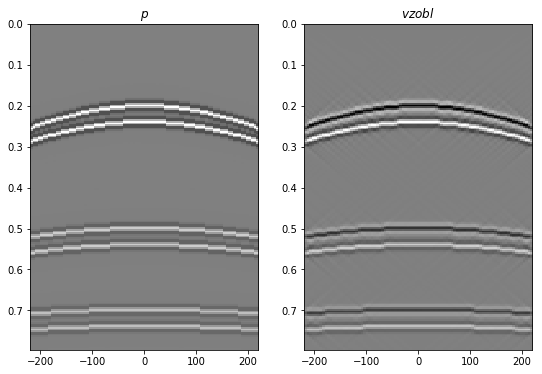

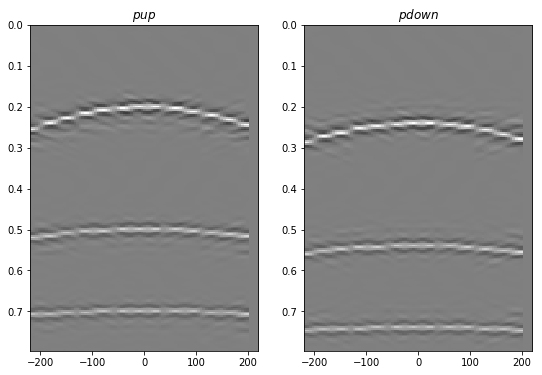

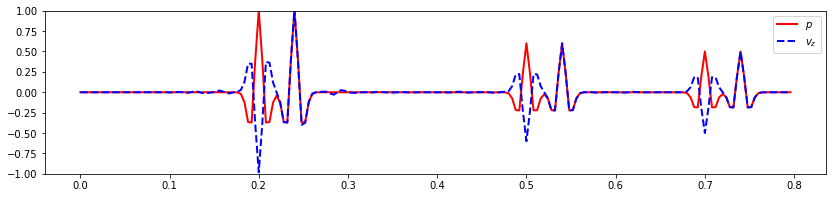

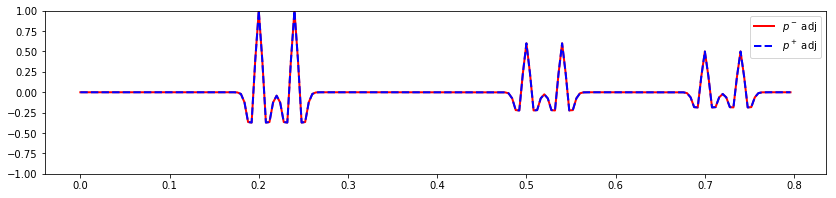

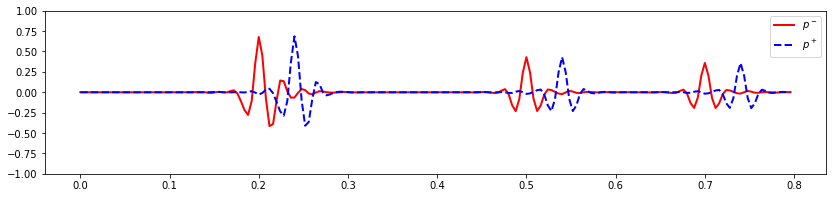

In [14]:
pup_inv, pdown_inv = WavefieldDecomposition(p_subsampled, vz.max()*vz_subsampled, par['nt'], par['nx'], 
                                            par['dt'], par['dx'], rho_sep, vel_sep, 
                                            nffts=(nfft, nfft), scaling= 1./vz.max(),
                                            critical=critical*100, ntaper=ntaper,
                                            sptransf=Slidop, restriction=Rop,
                                            dtype='complex128', **dict(damp=1e-10, iter_lim=50, show=2))

fig, axs = plt.subplots(1, 2, figsize=(9,6))
axs[0].imshow(p.T, cmap='gray', vmin=-np.abs(p).max(), vmax=np.abs(p).max(),
              extent = (x.min(),x.max(),t.max(),t.min()))
axs[0].set_title(r'$p$')
axs[0].axis('tight')
axs[1].imshow(vz_obl.T, cmap='gray', vmin=-np.abs(p).max(), vmax=np.abs(p).max(),
              extent = (x.min(),x.max(),t.max(),t.min()))
axs[1].set_title(r'$vzobl$')
axs[1].axis('tight')

fig, axs = plt.subplots(1, 2, figsize=(9,6))
axs[0].imshow(pup_inv.T, cmap='gray', vmin=-np.abs(p).max(), vmax=np.abs(p).max(),
              extent = (x.min(),x.max(),t.max(),t.min()))
axs[0].set_title(r'$pup$')
axs[0].axis('tight')
axs[1].imshow(pdown_inv.T, cmap='gray', vmin=-np.abs(p).max(), vmax=np.abs(p).max(),
              extent = (x.min(),x.max(),t.max(),t.min()))
axs[1].set_title(r'$pdown$')
axs[1].axis('tight')

plt.figure(figsize=(14, 3))
plt.plot(t, p[par['nx']//2], 'r', lw=2, label=r'$p$')
plt.plot(t, vz_obl[par['nx']//2], '--b', lw=2, label=r'$v_z$')
plt.ylim(-1, 1)
plt.legend()
plt.figure(figsize=(14, 3))
plt.plot(t, pup_adj[par['nx']//2], 'r', lw=2, label=r'$p^-$ adj')
plt.plot(t, pdown_adj[par['nx']//2], '--b', lw=2, label=r'$p^+$ adj')
plt.ylim(-1, 1)
plt.legend()
plt.figure(figsize=(14, 3))
plt.plot(t, pup_inv[par['nx']//2], 'r', lw=2, label=r'$p^-$')
plt.plot(t, pdown_inv[par['nx']//2], '--b', lw=2, label=r'$p^+$')
plt.ylim(-1, 1)
plt.legend();

Finally we use a sparse solver

FISTA optimization
-----------------------------------------------------------
The Operator Op has 5200 rows and 202000 cols
eps = 3.000000e-01	tol = 1.000000e-10	niter = 70
alpha = 1.652152e-03	thresh = 2.478228e-04
-----------------------------------------------------------

   Itn       x[0]        r2norm     r12norm     xupdate
     1  -0.00000e+00   4.580e+01   5.404e+01   2.105e-01
     2  -0.00000e+00   3.020e+01   4.429e+01   1.548e-01
     3  -0.00000e+00   1.862e+01   3.804e+01   1.491e-01
     4  -0.00000e+00   1.108e+01   3.483e+01   1.313e-01
     5  -0.00000e+00   6.644e+00   3.350e+01   1.087e-01
     6  -0.00000e+00   4.198e+00   3.298e+01   8.703e-02
     7  -0.00000e+00   2.910e+00   3.263e+01   6.977e-02
     8  -0.00000e+00   2.258e+00   3.217e+01   5.837e-02
     9  -0.00000e+00   1.953e+00   3.155e+01   5.215e-02
    10  -0.00000e+00   1.836e+00   3.083e+01   4.912e-02
    11  -0.00000e+00   1.813e+00   3.010e+01   4.749e-02
    21  -0.00000e+00   1.665e+00   2.58

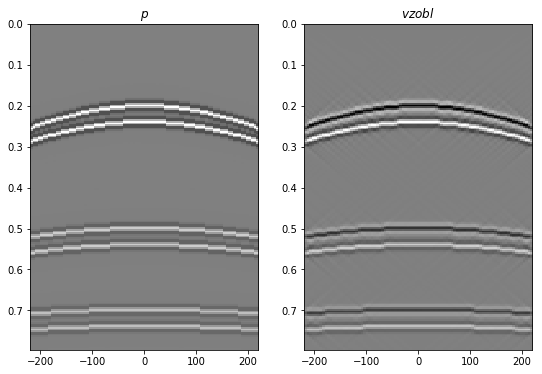

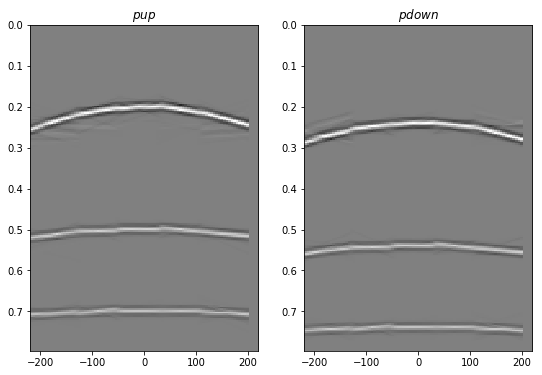

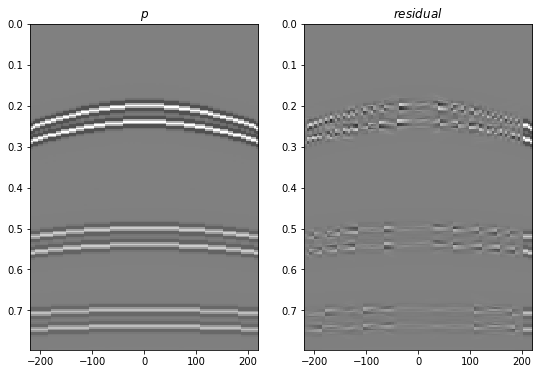

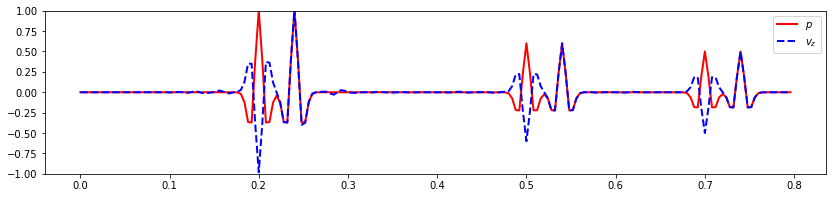

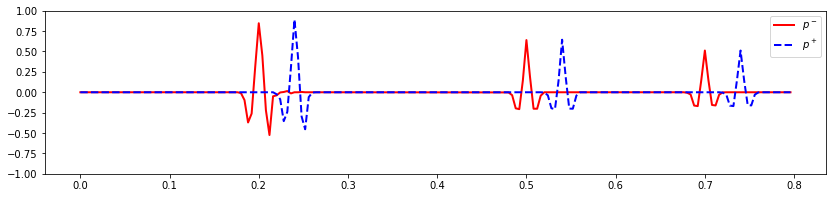

In [15]:
p_subsampled, vz_subsampled = d_subsampled[:Nsub], d_subsampled[Nsub:]

pup_inv, pdown_inv = WavefieldDecomposition(p_subsampled, vz.max()*vz_subsampled, par['nt'], par['nx'], 
                                            par['dt'], par['dx'], rho_sep, vel_sep, 
                                            nffts=(nfft, nfft), scaling= 1./vz.max(),
                                            critical=critical*100, ntaper=ntaper,
                                            sptransf=Slidop, restriction=Rop, solver=FISTA,
                                            dtype='complex128', 
                                            **dict(niter=70, eps=0.3, alpha=1.652152e-03, show=True))

fig, axs = plt.subplots(1, 2, figsize=(9,6))
axs[0].imshow(p.T, cmap='gray', vmin=-np.abs(p).max(), vmax=np.abs(p).max(),
              extent = (x.min(),x.max(),t.max(),t.min()))
axs[0].set_title(r'$p$')
axs[0].axis('tight')
axs[1].imshow(vz_obl.T, cmap='gray', vmin=-np.abs(p).max(), vmax=np.abs(p).max(),
              extent = (x.min(),x.max(),t.max(),t.min()))
axs[1].set_title(r'$vzobl$')
axs[1].axis('tight')

fig, axs = plt.subplots(1, 2, figsize=(9,6))
axs[0].imshow(pup_inv.T, cmap='gray', vmin=-np.abs(p).max(), vmax=np.abs(p).max(),
              extent = (x.min(),x.max(),t.max(),t.min()))
axs[0].set_title(r'$pup$')
axs[0].axis('tight')
axs[1].imshow(pdown_inv.T, cmap='gray', vmin=-np.abs(p).max(), vmax=np.abs(p).max(),
              extent = (x.min(),x.max(),t.max(),t.min()))
axs[1].set_title(r'$pdown$')
axs[1].axis('tight')

fig, axs = plt.subplots(1, 2, figsize=(9,6))
axs[0].imshow(p.T, cmap='gray', vmin=-np.abs(p).max(), vmax=np.abs(p).max(),
              extent = (x.min(),x.max(),t.max(),t.min()))
axs[0].set_title(r'$p$')
axs[0].axis('tight')
axs[1].imshow(p.T-(pdown_inv.T+pup_inv.T), cmap='gray', vmin=-np.abs(p).max(), vmax=np.abs(p).max(),
              extent = (x.min(),x.max(),t.max(),t.min()))
axs[1].set_title(r'$residual$')
axs[1].axis('tight')

plt.figure(figsize=(14, 3))
plt.plot(t, p[par['nx']//2], 'r', lw=2, label=r'$p$')
plt.plot(t, vz_obl[par['nx']//2], '--b', lw=2, label=r'$v_z$')
plt.ylim(-1, 1)
plt.legend()
plt.figure(figsize=(14, 3))
plt.plot(t, pup_inv[par['nx']//2], 'r', lw=2, label=r'$p^-$')
plt.plot(t, pdown_inv[par['nx']//2], '--b', lw=2, label=r'$p^+$')
plt.ylim(-1, 1)
plt.legend();

And we repeat the same using the Wavelet operator as sparsifying transform

FISTA optimization
-----------------------------------------------------------
The Operator Op has 5200 rows and 65536 cols
eps = 1.000000e-01	tol = 1.000000e-10	niter = 100
alpha = 5.000000e-01	thresh = 2.500000e-02
-----------------------------------------------------------

   Itn       x[0]        r2norm     r12norm     xupdate
     1  -0.00000e+00   2.112e+01   4.545e+01   5.823e+00
     2  -0.00000e+00   1.438e+01   4.142e+01   1.741e+00
     3  -0.00000e+00   1.006e+01   3.924e+01   1.550e+00
     4  -0.00000e+00   7.403e+00   3.811e+01   1.322e+00
     5  -0.00000e+00   5.844e+00   3.745e+01   1.113e+00
     6  -0.00000e+00   4.936e+00   3.697e+01   9.459e-01
     7  -0.00000e+00   4.408e+00   3.653e+01   8.300e-01
     8  -0.00000e+00   4.093e+00   3.608e+01   7.572e-01
     9  -0.00000e+00   3.905e+00   3.564e+01   7.093e-01
    10  -0.00000e+00   3.802e+00   3.522e+01   6.756e-01
    11  -0.00000e+00   3.738e+00   3.485e+01   6.415e-01
    21  -0.00000e+00   3.492e+00   3.35

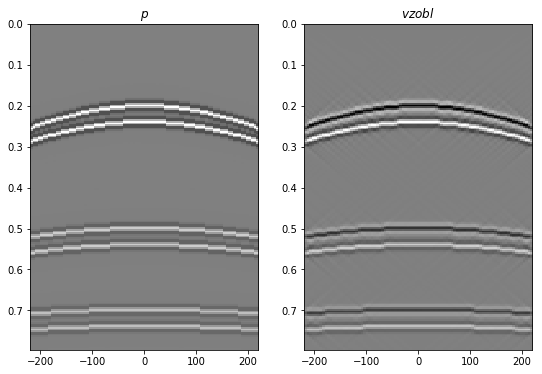

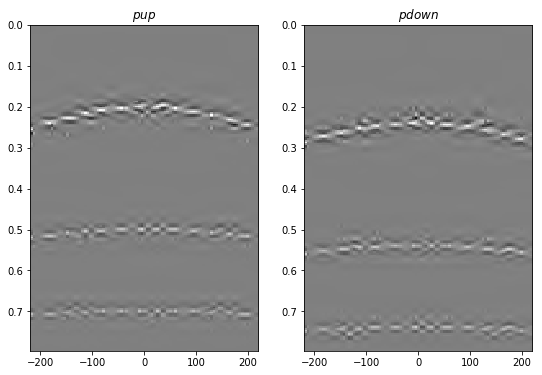

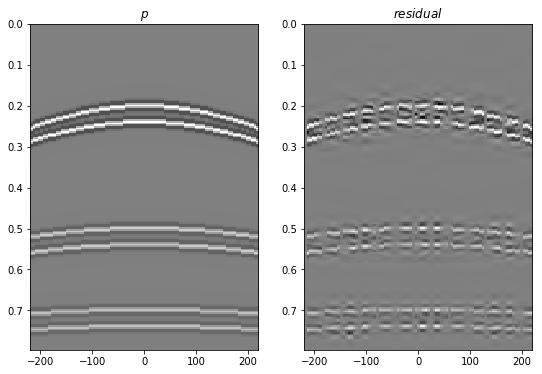

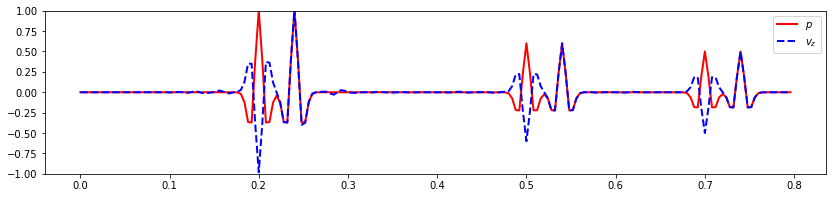

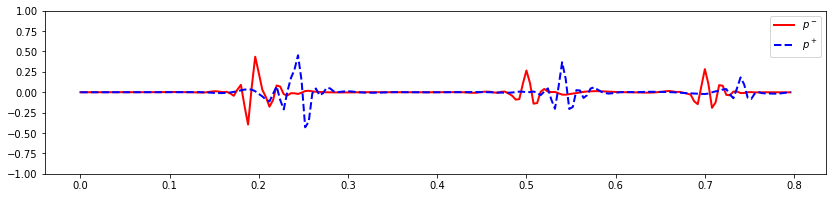

In [53]:
Wavop = DWT2D((par['nx'], par['nt']), wavelet='sym10', level=4)

pup_inv, pdown_inv = WavefieldDecomposition(p_subsampled, vz.max()*vz_subsampled, par['nt'], par['nx'], 
                                            par['dt'], par['dx'], rho_sep, vel_sep, 
                                            nffts=(nfft, nfft), scaling= 1./vz.max(),
                                            critical=critical*100, ntaper=ntaper,
                                            sptransf=Wavop.H, restriction=Rop, solver=FISTA,
                                            dtype='complex128', 
                                            **dict(niter=100, eps=1e-1, 
                                                   alpha = 5.000000e-01, 
                                                   show=True))

fig, axs = plt.subplots(1, 2, figsize=(9,6))
axs[0].imshow(p.T, cmap='gray', vmin=-np.abs(p).max(), vmax=np.abs(p).max(),
              extent = (x.min(),x.max(),t.max(),t.min()))
axs[0].set_title(r'$p$')
axs[0].axis('tight')
axs[1].imshow(vz_obl.T, cmap='gray', vmin=-np.abs(p).max(), vmax=np.abs(p).max(),
              extent = (x.min(),x.max(),t.max(),t.min()))
axs[1].set_title(r'$vzobl$')
axs[1].axis('tight')

fig, axs = plt.subplots(1, 2, figsize=(9,6))
axs[0].imshow(pup_inv.T, cmap='gray', vmin=-np.abs(p).max(), vmax=np.abs(p).max(),
              extent = (x.min(),x.max(),t.max(),t.min()))
axs[0].set_title(r'$pup$')
axs[0].axis('tight')
axs[1].imshow(pdown_inv.T, cmap='gray', vmin=-np.abs(p).max(), vmax=np.abs(p).max(),
              extent = (x.min(),x.max(),t.max(),t.min()))
axs[1].set_title(r'$pdown$')
axs[1].axis('tight')

fig, axs = plt.subplots(1, 2, figsize=(9,6))
axs[0].imshow(p.T, cmap='gray', vmin=-np.abs(p).max(), vmax=np.abs(p).max(),
              extent = (x.min(),x.max(),t.max(),t.min()))
axs[0].set_title(r'$p$')
axs[0].axis('tight')
axs[1].imshow(p.T-(pdown_inv.T+pup_inv.T), cmap='gray', vmin=-np.abs(p).max(), vmax=np.abs(p).max(),
              extent = (x.min(),x.max(),t.max(),t.min()))
axs[1].set_title(r'$residual$')
axs[1].axis('tight')

plt.figure(figsize=(14, 3))
plt.plot(t, p[par['nx']//2], 'r', lw=2, label=r'$p$')
plt.plot(t, vz_obl[par['nx']//2], '--b', lw=2, label=r'$v_z$')
plt.ylim(-1, 1)
plt.legend()
plt.figure(figsize=(14, 3))
plt.plot(t, pup_inv[par['nx']//2], 'r', lw=2, label=r'$p^-$')
plt.plot(t, pdown_inv[par['nx']//2], '--b', lw=2, label=r'$p^+$')
plt.ylim(-1, 1)
plt.legend();

# 3D

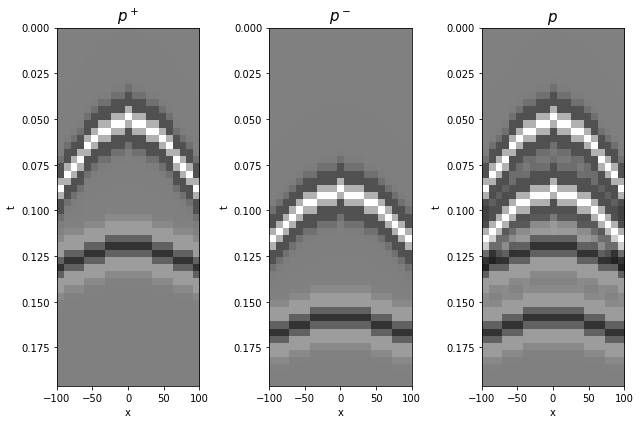

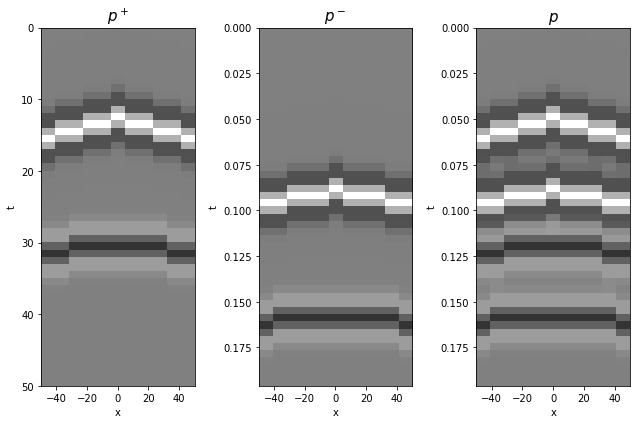

In [137]:
###### Input parameters
"""
par = {'ox':-220,  'dx':5,    'nx':89,
       'oy':-300,  'dy':5,    'ny':121,
       'ot':0,     'dt':0.004, 'nt':200,
       'f0': 40}

t0_minus = np.array([0.2,0.5,0.7])
t0_plus = t0_minus + 0.04
vrms = np.array([1400.,1500., 2000.])
amp = np.array([1.,0.6,0.5])
vel_sep = 900.0 # velocity at separation level
rho_sep = 1000.0 # density at separation level
"""

par = {'ox': -100, 'dx': 10, 'nx': 21,
       'oy': -50, 'dy': 10, 'ny': 11,
       'ot': 0, 'dt': 0.004, 'nt': 50,
       'f0': 40}

t0_plus = np.array([0.05, 0.12])
t0_minus = t0_plus + 0.04
vrms = np.array([1400., 1800.])
amp = np.array([1., -0.6])
vel_sep = 1000.0 # velocity at separation level
rho_sep = 1000.0 # density at separation level


# Create axis
t,t2,x,y = makeaxis(par)

# Create wavelet
wav = ricker(t[:41], f0=par['f0'])[0]

# Create data
_, p_minus = hyperbolic3d(x, y, t, t0_minus, vrms, vrms, amp, wav)
_, p_plus = hyperbolic3d(x, y, t, t0_plus, vrms, vrms, amp, wav)
p = p_plus + p_minus


plt.figure(figsize=(9,6))
plt.subplot(131)
plt.imshow(p_plus[par['ny']//2].T,aspect='auto',interpolation='nearest', cmap='gray',
           extent=(x.min(),x.max(),t.max(),t.min()), vmin=-1, vmax=1)
plt.title(r'$p^+$', fontsize=15)
plt.xlabel('x'),plt.ylabel('t')

plt.subplot(132)
plt.imshow(p_minus[par['ny']//2].T,aspect='auto',interpolation='nearest', cmap='gray',
           extent=(x.min(),x.max(),t.max(),t.min()), vmin=-1, vmax=1)
plt.title(r'$p^-$', fontsize=15)
plt.xlabel('x'),plt.ylabel('t')
plt.tight_layout()

plt.subplot(133)
plt.imshow(p[par['ny']//2].T,aspect='auto',interpolation='nearest', cmap='gray',
           extent=(x.min(),x.max(),t.max(),t.min()), vmin=-1, vmax=1)
plt.title(r'$p$', fontsize=15)
plt.xlabel('x'),plt.ylabel('t')
plt.tight_layout()

plt.figure(figsize=(9,6))
plt.subplot(131)
plt.imshow(p_plus[:, par['nx']//2].T,aspect='auto',interpolation='nearest', cmap='gray',
           extent=(y.min(),y.max(),y.max(),t.min()), vmin=-1, vmax=1)
plt.title(r'$p^+$', fontsize=15)
plt.xlabel('x'),plt.ylabel('t')

plt.subplot(132)
plt.imshow(p_minus[:, par['nx']//2].T,aspect='auto',interpolation='nearest', cmap='gray',
           extent=(y.min(),y.max(),t.max(),t.min()), vmin=-1, vmax=1)
plt.title(r'$p^-$', fontsize=15)
plt.xlabel('x'),plt.ylabel('t')
plt.tight_layout()

plt.subplot(133)
plt.imshow(p[:, par['nx']//2].T,aspect='auto',interpolation='nearest', cmap='gray',
           extent=(y.min(),y.max(),t.max(),t.min()), vmin=-1, vmax=1)
plt.title(r'$p$', fontsize=15)
plt.xlabel('x'),plt.ylabel('t')
plt.tight_layout()

## 0. Wavefield composition

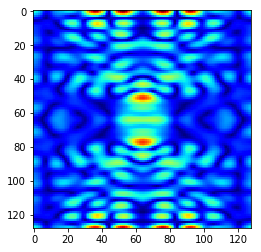

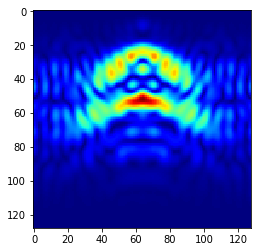

In [138]:
nfft=2**8
nfftk=2**7
FFTop = FFTND(dims=[par['ny'], par['nx'], par['nt']], nffts=[nfftk, nfftk, nfft], 
              sampling=[par['dy'], par['dx'], par['dt']])
dottest(FFTop, nfftk*nfftk*nfft, par['nt']*par['nx']*par['ny'], complexflag=2)

P = FFTop*p.flatten()
P = P.reshape(nfftk, nfftk, nfft)

plt.figure()
plt.imshow(np.fft.fftshift(np.fft.fftshift(np.abs(P[..., 110]),axes=0),axes=1).T, cmap='jet')   

plt.figure()
plt.imshow(np.fft.fftshift(np.abs(P[10, :, :nfft//2]),axes=0).T, cmap='jet')   

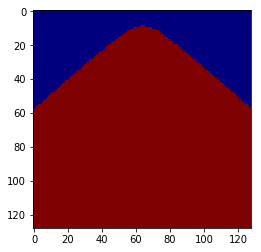

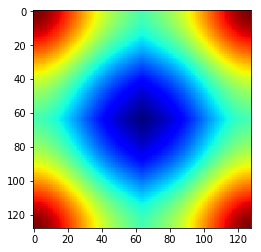

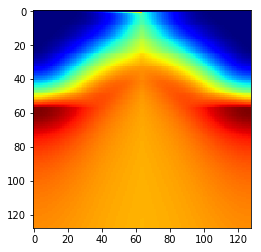

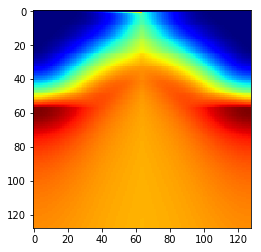

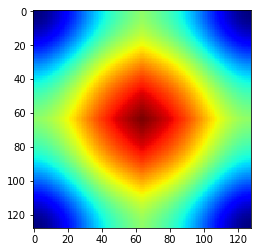

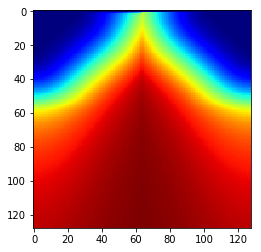

In [139]:
critical = 0.9
ntaper = 41

#obliquity factor
[Ky, Kx, F] = np.meshgrid(FFTop.fs[0], FFTop.fs[1], FFTop.fs[2], indexing='ij')
k=F/vel_sep
Kz=np.sqrt((k**2-Ky**2-Kx**2).astype(np.complex))
Kz[np.isnan(Kz)] = 0

OBL=rho_sep*(np.abs(F)/Kz)
OBL[Kz==0]=0

# cut off and taper
mask = np.sqrt(Kx**2+Ky**2)<critical*np.abs(F)/vel_sep
OBL = OBL*mask
OBL = filtfilt(np.ones(ntaper)/float(ntaper), 1, OBL, axis=0)
OBL = filtfilt(np.ones(ntaper)/float(ntaper), 1, OBL, axis=1)

OBL1 = Kz /(rho_sep*np.abs(F))
OBL1[F==0] = 0
OBL1 = OBL1*mask
OBL1 = filtfilt(np.ones(ntaper)/float(ntaper), 1, OBL1, axis=0)
OBL1 = filtfilt(np.ones(ntaper)/float(ntaper), 1, OBL1, axis=1)

OBLop = Diagonal(OBL1.flatten(), dtype='complex128')

plt.figure()
plt.imshow(np.fft.fftshift(np.abs(mask[10, :, :nfft//2]),axes=0).T, cmap='jet')   

plt.figure()
plt.imshow(np.fft.fftshift(np.fft.fftshift(np.abs(OBL[..., 110]),axes=0),axes=1).T, cmap='jet')   
plt.figure()
plt.imshow(np.fft.fftshift(np.abs(OBL[10, :, :nfft//2]),axes=0).T, cmap='jet')   
plt.figure()
plt.imshow(np.fft.fftshift(np.abs(OBL[:, 10, :nfft//2]),axes=0).T, cmap='jet')   

plt.figure()
plt.imshow(np.fft.fftshift(np.fft.fftshift(np.abs(OBL1[..., 110]),axes=0),axes=1).T, cmap='jet')   
plt.figure()
plt.imshow(np.fft.fftshift(np.abs(OBL1[10, :, :nfft//2]),axes=0).T, cmap='jet');

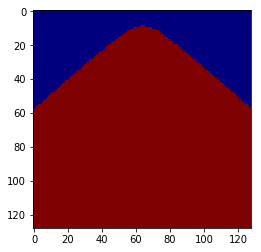

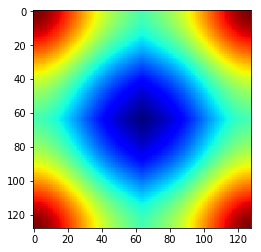

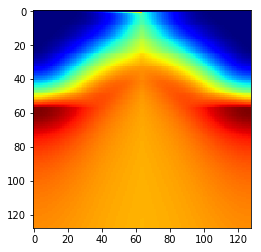

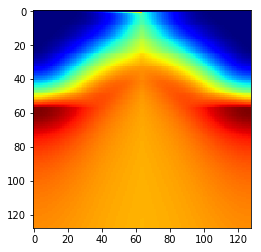

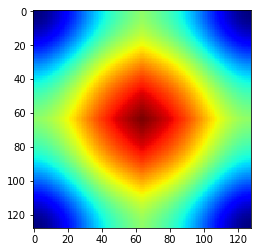

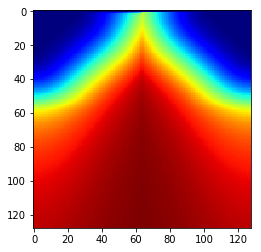

In [140]:
plt.figure()
plt.imshow(np.fft.fftshift(np.abs(mask[10, :, :nfft//2]),axes=0).T, cmap='jet')   

plt.figure()
plt.imshow(np.fft.fftshift(np.fft.fftshift(np.abs(OBL[..., 110]),axes=0),axes=1).T, cmap='jet')   
plt.figure()
plt.imshow(np.fft.fftshift(np.abs(OBL[10, :, :nfft//2]),axes=0).T, cmap='jet')   
plt.figure()
plt.imshow(np.fft.fftshift(np.abs(OBL[:, 10, :nfft//2]),axes=0).T, cmap='jet')   

plt.figure()
plt.imshow(np.fft.fftshift(np.fft.fftshift(np.abs(OBL1[..., 110]),axes=0),axes=1).T, cmap='jet')   
plt.figure()
plt.imshow(np.fft.fftshift(np.abs(OBL1[10, :, :nfft//2]),axes=0).T, cmap='jet');

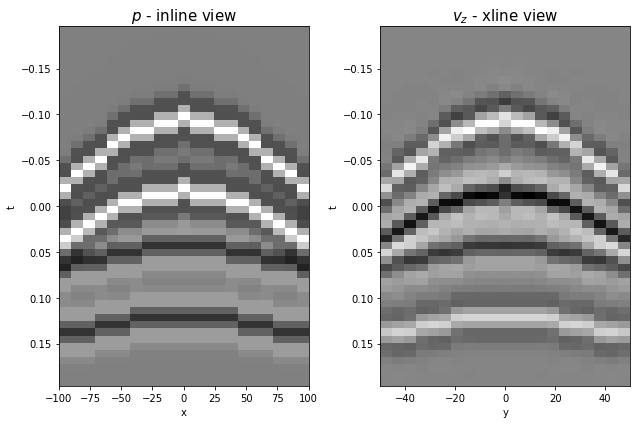

In [141]:
# wavefield modelling
S1op = (BlockDiag([FFTop.H, FFTop.H])*\
        Block([[Identity(nfftk*nfftk*nfft, dtype='complex128'), Identity(nfftk*nfftk*nfft, dtype='complex128')],
               [OBLop, -OBLop]])*\
        BlockDiag([FFTop, FFTop]))
dottest(S1op, 2*par['nt']*par['nx']*par['ny'], 2*par['nt']*par['nx']*par['ny'], tol=1e-4)

p_sep = np.concatenate((p_plus.flatten(), p_minus.flatten()))
d = S1op * p_sep.flatten()
d = np.real(d.reshape(2*par['ny'], par['nx'], par['nt']))
p, vz = d[:par['ny']], d[par['ny']:]

plt.figure(figsize=(9,6))
plt.subplot(121)
plt.imshow(p[par['ny']//2].T, aspect='auto',interpolation='nearest', cmap='gray',
           extent=(x.min(),x.max(),t2.max(),t2.min()), vmin=-1, vmax=1)
plt.title(r'$p$ - inline view', fontsize=15)
plt.xlabel('x'),plt.ylabel('t')
plt.subplot(122)
plt.imshow(vz[par['ny']//2].T, aspect='auto',interpolation='nearest', cmap='gray',
           extent=(y.min(),y.max(),t2.max(),t2.min()))
plt.title(r'$v_z$ - xline view', fontsize=15)
plt.xlabel('y'),plt.ylabel('t')
plt.tight_layout()

## 1. Analytical decomposition

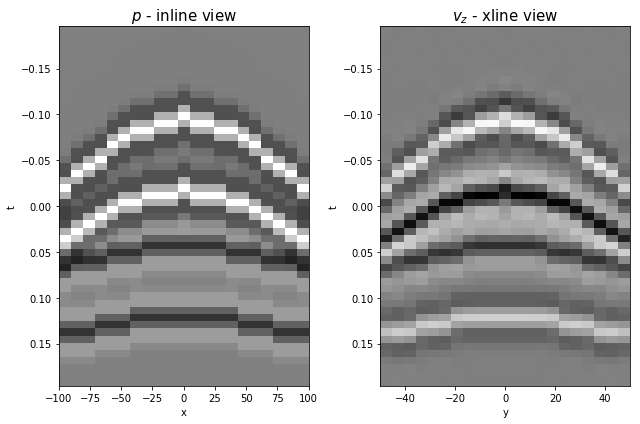

In [142]:
S1op_scaled = (BlockDiag([FFTop.H, (1./vz.max())*FFTop.H])*\
        Block([[Identity(nfftk*nfftk*nfft, dtype='complex128'), Identity(nfftk*nfftk*nfft, dtype='complex128')],
               [OBLop, -OBLop]])*\
        BlockDiag([FFTop, FFTop]))

d_scaled = S1op_scaled * p_sep.flatten()
d_scaled = np.real(d_scaled.reshape(2*par['ny'], par['nx'], par['nt']))
p, vz_scaled = d_scaled[:par['ny']], d_scaled[par['ny']:]

plt.figure(figsize=(9,6))
plt.subplot(121)
plt.imshow(p[par['ny']//2].T, aspect='auto',interpolation='nearest', cmap='gray',
           extent=(x.min(),x.max(),t2.max(),t2.min()), vmin=-1, vmax=1)
plt.title(r'$p$ - inline view', fontsize=15)
plt.xlabel('x'),plt.ylabel('t')
plt.subplot(122)
plt.imshow(vz_scaled[par['ny']//2].T, aspect='auto',interpolation='nearest', cmap='gray',
           extent=(y.min(),y.max(),t2.max(),t2.min()), vmin=-1, vmax=1)
plt.title(r'$v_z$ - xline view', fontsize=15)
plt.xlabel('y'),plt.ylabel('t')
plt.tight_layout()

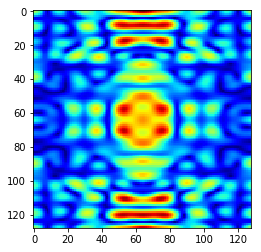

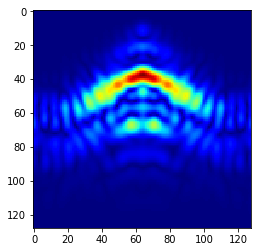

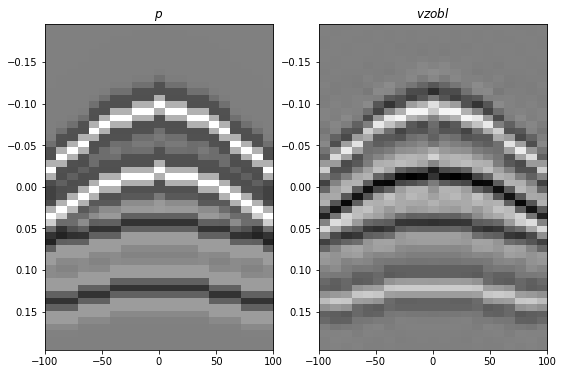

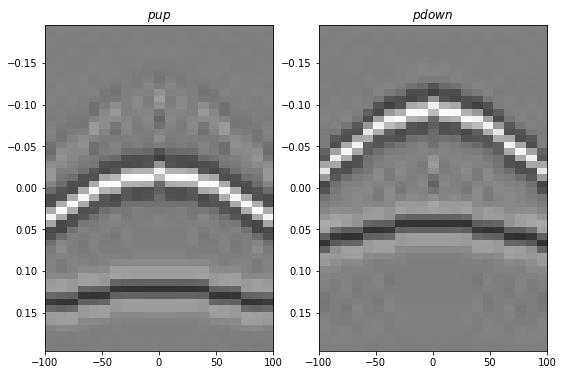

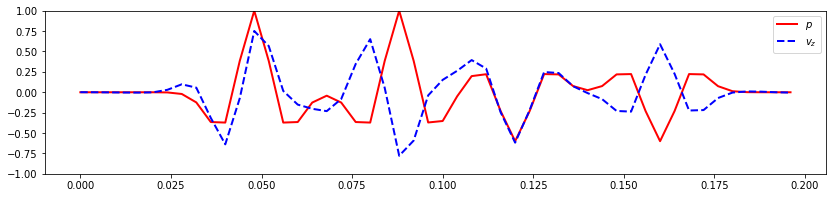

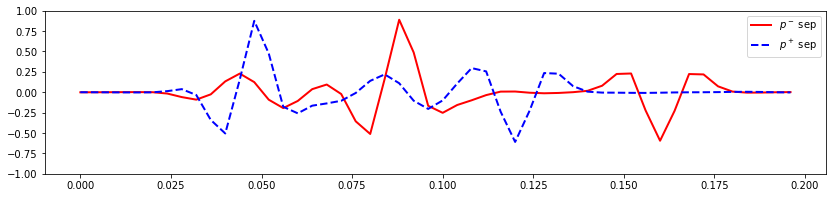

In [143]:
VZ = FFTop*vz.flatten()
VZ = VZ.reshape(nfftk, nfftk, nfft)

# scaled Vz
VZ_obl = OBL*VZ;
vz_obl = FFTop.H*VZ_obl.flatten()
vz_obl = np.real(vz_obl.reshape(par['ny'], par['nx'], par['nt']))

p = FFTop.H*P.flatten()
p = np.real(p.reshape(par['ny'], par['nx'], par['nt']))

# separation
pup_sep=(p-vz_obl)/2;
pdown_sep=(p+vz_obl)/2;

plt.figure()
plt.imshow(np.fft.fftshift(np.fft.fftshift(np.abs(VZ_obl[..., 110]),axes=0),axes=1).T, cmap='jet')   
plt.figure()
plt.imshow(np.fft.fftshift(np.abs(VZ_obl[10, :, :nfft//2]),axes=0).T, cmap='jet')   

fig, axs = plt.subplots(1, 2, figsize=(9,6))
axs[0].imshow(p[par['ny']//2].T, cmap='gray',            
              extent=(x.min(),x.max(),t2.max(),t2.min()), 
              vmin=-1, vmax=1)
axs[0].set_title(r'$p$')
axs[0].axis('tight')
axs[1].imshow(vz_obl[par['ny']//2].T, cmap='gray',            
              extent=(x.min(),x.max(),t2.max(),t2.min()), 
              vmin=-1, vmax=1)
axs[1].set_title(r'$vzobl$')
axs[1].axis('tight')

fig, axs = plt.subplots(1, 2, figsize=(9,6))
axs[0].imshow(pup_sep[par['ny']//2].T, cmap='gray',            
              extent=(x.min(),x.max(),t2.max(),t2.min()), 
              vmin=-1, vmax=1)
axs[0].set_title(r'$pup$')
axs[0].axis('tight')
axs[1].imshow(pdown_sep[par['ny']//2].T, cmap='gray',            
              extent=(x.min(),x.max(),t2.max(),t2.min()), 
              vmin=-1, vmax=1)
axs[1].set_title(r'$pdown$')
axs[1].axis('tight')

plt.figure(figsize=(14, 3))
plt.plot(t, p[par['ny']//2, par['nx']//2], 'r', lw=2, label=r'$p$')
plt.plot(t, vz_obl[par['ny']//2, par['nx']//2], '--b', lw=2, label=r'$v_z$')
plt.ylim(-1, 1)
plt.legend()
plt.figure(figsize=(14, 3))
plt.plot(t, pup_sep[par['ny']//2, par['nx']//2], 'r', lw=2, label=r'$p^-$ sep')
plt.plot(t, pdown_sep[par['ny']//2, par['nx']//2], '--b', lw=2, label=r'$p^+$ sep')
plt.ylim(-1, 1)
plt.legend();

Use function

Ky.shape (128, 128, 256)
Kx.shape (128, 128, 256)
(4194304,) (11, 21, 50)


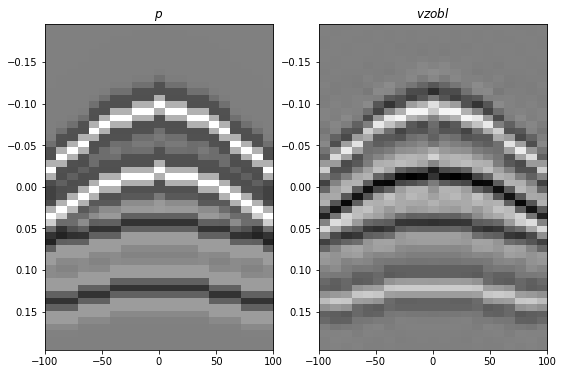

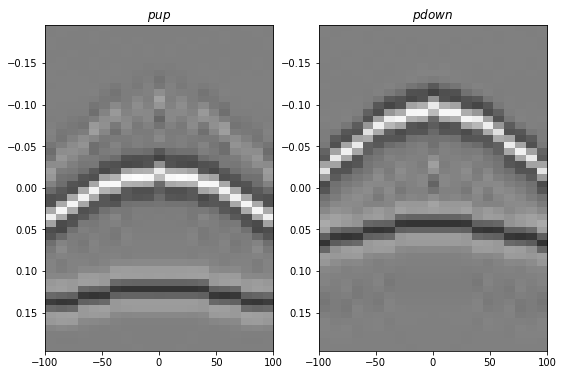

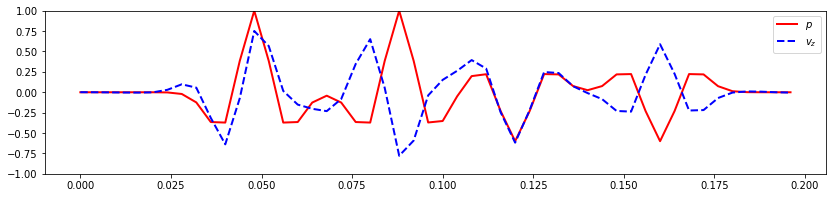

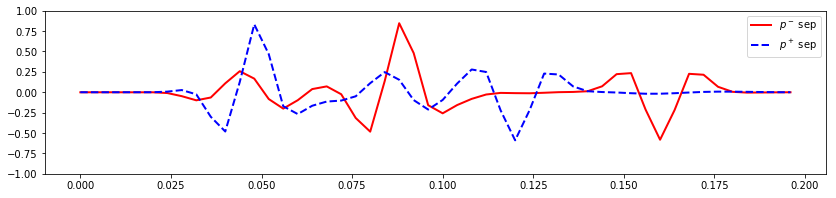

In [144]:
pup_sep, pdown_sep = \
    WavefieldDecomposition(p, vz, par['nt'], (par['ny'], par['nx']), par['dt'], (par['dy'], par['dx']), 
                           rho_sep, vel_sep, nffts=(nfftk, nfftk, nfft), kind='analytical',
                           critical=critical*100, ntaper=ntaper, dtype='complex128')

fig, axs = plt.subplots(1, 2, figsize=(9,6))
axs[0].imshow(p[par['ny']//2].T, cmap='gray',            
              extent=(x.min(),x.max(),t2.max(),t2.min()), 
              vmin=-1, vmax=1)
axs[0].set_title(r'$p$')
axs[0].axis('tight')
axs[1].imshow(vz_obl[par['ny']//2].T, cmap='gray',            
              extent=(x.min(),x.max(),t2.max(),t2.min()), 
              vmin=-1, vmax=1)
axs[1].set_title(r'$vzobl$')
axs[1].axis('tight')

fig, axs = plt.subplots(1, 2, figsize=(9,6))
axs[0].imshow(pup_sep[par['ny']//2].T, cmap='gray',            
              extent=(x.min(),x.max(),t2.max(),t2.min()), 
              vmin=-1, vmax=1)
axs[0].set_title(r'$pup$')
axs[0].axis('tight')
axs[1].imshow(pdown_sep[par['ny']//2].T, cmap='gray',            
              extent=(x.min(),x.max(),t2.max(),t2.min()), 
              vmin=-1, vmax=1)
axs[1].set_title(r'$pdown$')
axs[1].axis('tight')

plt.figure(figsize=(14, 3))
plt.plot(t, p[par['ny']//2, par['nx']//2], 'r', lw=2, label=r'$p$')
plt.plot(t, vz_obl[par['ny']//2, par['nx']//2], '--b', lw=2, label=r'$v_z$')
plt.ylim(-1, 1)
plt.legend()
plt.figure(figsize=(14, 3))
plt.plot(t, pup_sep[par['ny']//2, par['nx']//2], 'r', lw=2, label=r'$p^-$ sep')
plt.plot(t, pdown_sep[par['ny']//2, par['nx']//2], '--b', lw=2, label=r'$p^+$ sep')
plt.ylim(-1, 1)
plt.legend();

## 2. Wavefield separation by inversion

 
LSQR            Least-squares solution of  Ax = b
The matrix A has    23100 rows  and    23100 cols
damp = 1.00000000000000e-10   calc_var =        0
atol = 1.00e-08                 conlim = 1.00e+08
btol = 1.00e-08               iter_lim =       10
 
   Itn      x[0]       r1norm     r2norm   Compatible    LS      Norm A   Cond A
     0  0.00000e+00   4.542e+01  4.542e+01    1.0e+00  3.0e-02
     1 -2.72356e-04   7.021e+00  7.021e+00    1.5e-01  7.6e-01   1.4e+00  1.0e+00
     2 -4.25550e-04   2.640e+00  2.640e+00    5.8e-02  4.8e-01   1.8e+00  2.1e+00
     3 -3.88858e-04   1.492e+00  1.492e+00    3.3e-02  3.4e-01   2.1e+00  3.2e+00
     4 -1.60082e-04   1.014e+00  1.014e+00    2.2e-02  2.7e-01   2.4e+00  4.5e+00
     5  3.08630e-04   7.355e-01  7.355e-01    1.6e-02  2.1e-01   2.6e+00  6.0e+00
     6  8.08840e-04   5.667e-01  5.667e-01    1.2e-02  1.8e-01   2.8e+00  7.7e+00
     7  1.45390e-03   4.536e-01  4.536e-01    1.0e-02  1.6e-01   3.0e+00  9.4e+00
     8  1.59984e-03   3.760e

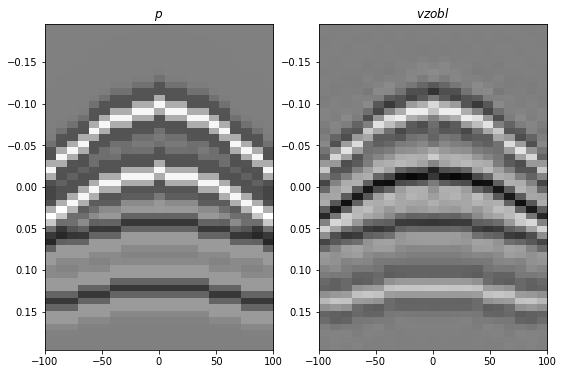

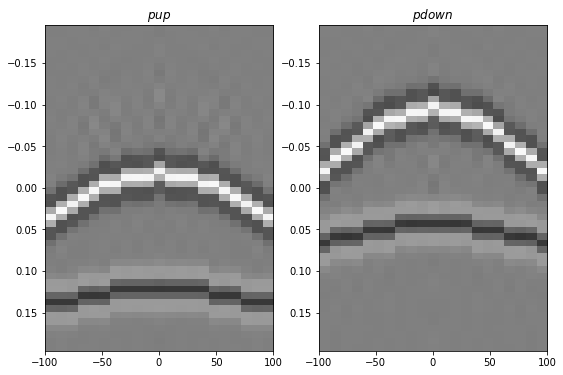

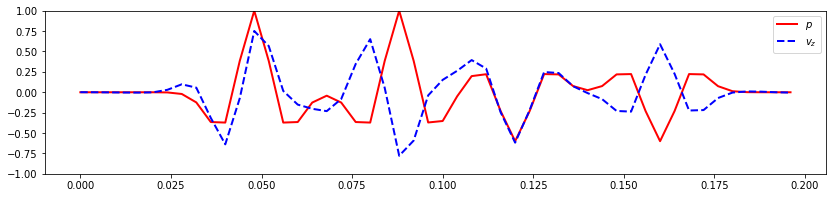

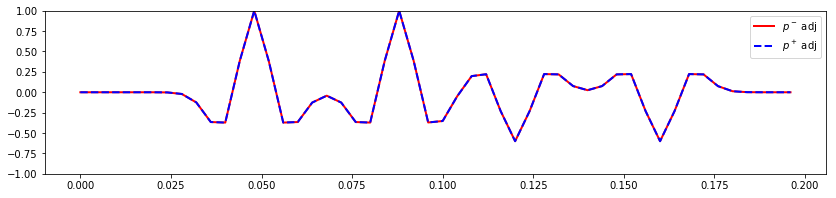

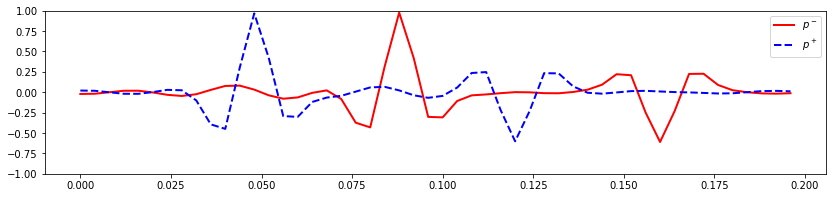

In [145]:
# adjoint and inverse
dud_adj = np.real(S1op_scaled.H * d.flatten())
dud_inv, istop, itn, r1norm, r2norm = lsqr(S1op_scaled, d_scaled.flatten(), 
                                           damp=1e-10, iter_lim=10, show=2)[0:5]
dud_inv = np.real(dud_inv)

dud_adj = dud_adj.reshape(2*par['ny'], par['nx'], par['nt'])
dud_inv = dud_inv.reshape(2*par['ny'], par['nx'], par['nt'])

pdown_adj, pup_adj= dud_adj[:par['ny']], dud_adj[par['ny']:]
pdown_inv, pup_inv= dud_inv[:par['ny']], dud_inv[par['ny']:]

fig, axs = plt.subplots(1, 2, figsize=(9,6))
axs[0].imshow(p[par['ny']//2].T, cmap='gray', vmin=-np.abs(p).max(), vmax=np.abs(p).max(),
              extent = (x.min(),x.max(),t2.max(),t2.min()))
axs[0].set_title(r'$p$')
axs[0].axis('tight')
axs[1].imshow(vz_obl[par['ny']//2].T, cmap='gray', vmin=-np.abs(p).max(), vmax=np.abs(p).max(),
              extent = (x.min(),x.max(),t2.max(),t2.min()))
axs[1].set_title(r'$vzobl$')
axs[1].axis('tight')

fig, axs = plt.subplots(1, 2, figsize=(9,6))
axs[0].imshow(pup_inv[par['ny']//2].T, cmap='gray', vmin=-np.abs(p).max(), vmax=np.abs(p).max(),
              extent = (x.min(),x.max(),t2.max(),t2.min()))
axs[0].set_title(r'$pup$')
axs[0].axis('tight')
axs[1].imshow(pdown_inv[par['ny']//2].T, cmap='gray', vmin=-np.abs(p).max(), vmax=np.abs(p).max(),
              extent = (x.min(),x.max(),t2.max(),t2.min()))
axs[1].set_title(r'$pdown$')
axs[1].axis('tight')

plt.figure(figsize=(14, 3))
plt.plot(t, p[par['ny']//2, par['nx']//2], 'r', lw=2, label=r'$p$')
plt.plot(t, vz_obl[par['ny']//2, par['nx']//2], '--b', lw=2, label=r'$v_z$')
plt.ylim(-1, 1)
plt.legend()
plt.figure(figsize=(14, 3))
plt.plot(t, pup_adj[par['ny']//2, par['nx']//2], 'r', lw=2, label=r'$p^-$ adj')
plt.plot(t, pdown_adj[par['ny']//2, par['nx']//2], '--b', lw=2, label=r'$p^+$ adj')
plt.ylim(-1, 1)
plt.legend()
plt.figure(figsize=(14, 3))
plt.plot(t, pup_inv[par['ny']//2, par['nx']//2], 'r', lw=2, label=r'$p^-$')
plt.plot(t, pdown_inv[par['ny']//2, par['nx']//2], '--b', lw=2, label=r'$p^+$')
plt.ylim(-1, 1)
plt.legend();

Use function

Ky.shape (128, 128, 256)
Kx.shape (128, 128, 256)
 
LSQR            Least-squares solution of  Ax = b
The matrix A has    23100 rows  and    23100 cols
damp = 1.00000000000000e-10   calc_var =        0
atol = 1.00e-08                 conlim = 1.00e+08
btol = 1.00e-08               iter_lim =       10
 
   Itn      x[0]       r1norm     r2norm   Compatible    LS      Norm A   Cond A
     0  0.00000e+00   3.432e+01  3.432e+01    1.0e+00  4.1e-02
     1 -1.53261e-16   2.795e-05  2.795e-05    8.1e-07  8.2e-07   1.4e+00  1.0e+00
     2 -6.96119e-12   2.795e-05  2.795e-05    8.1e-07  1.9e-04   1.4e+00  2.4e+02
     3 -1.87525e-04   7.375e-06  7.375e-06    2.1e-07  4.9e-07   2.0e+00  1.7e+06
     4 -1.87531e-04   7.375e-06  7.375e-06    2.1e-07  4.8e-03   2.0e+00  1.7e+06
     5 -2.95167e-04   2.981e-06  2.981e-06    8.7e-08  3.4e-07   2.4e+00  3.1e+06
     6 -2.98589e-04   2.933e-06  2.933e-06    8.5e-08  1.0e-01   2.4e+00  3.2e+06
     7 -3.73147e-04   1.575e-06  1.575e-06    4.6e-08  2.6e-

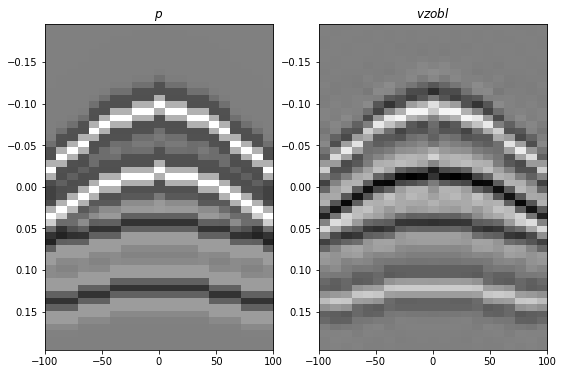

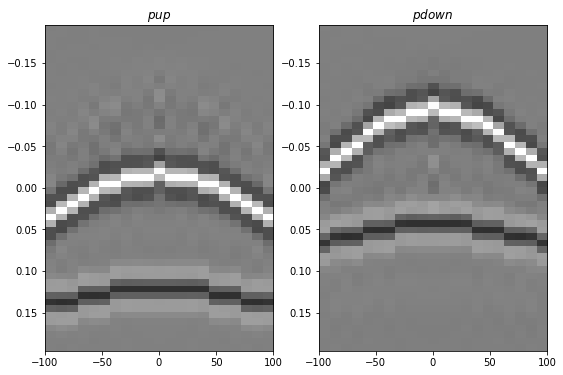

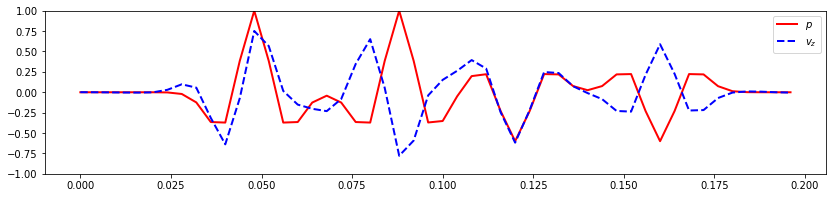

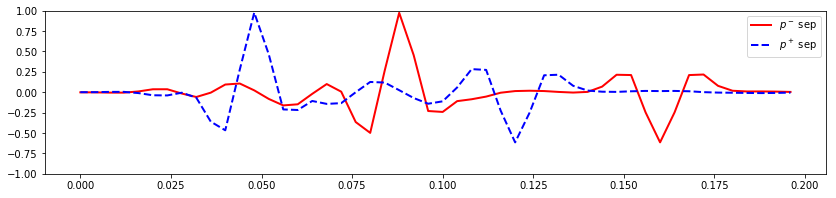

In [146]:
pup_sep, pdown_sep = \
    WavefieldDecomposition(p, vz, par['nt'], (par['ny'], par['nx']), par['dt'], (par['dy'], par['dx']), 
                           rho_sep, vel_sep, nffts=(nfftk, nfftk, nfft), kind='inverse',
                           critical=critical*100, ntaper=ntaper, dtype='complex128', 
                           **dict(damp=1e-10, iter_lim=10, show=2))

fig, axs = plt.subplots(1, 2, figsize=(9,6))
axs[0].imshow(p[par['ny']//2].T, cmap='gray',            
              extent=(x.min(),x.max(),t2.max(),t2.min()), 
              vmin=-1, vmax=1)
axs[0].set_title(r'$p$')
axs[0].axis('tight')
axs[1].imshow(vz_obl[par['ny']//2].T, cmap='gray',            
              extent=(x.min(),x.max(),t2.max(),t2.min()), 
              vmin=-1, vmax=1)
axs[1].set_title(r'$vzobl$')
axs[1].axis('tight')

fig, axs = plt.subplots(1, 2, figsize=(9,6))
axs[0].imshow(pup_sep[par['ny']//2].T, cmap='gray',            
              extent=(x.min(),x.max(),t2.max(),t2.min()), 
              vmin=-1, vmax=1)
axs[0].set_title(r'$pup$')
axs[0].axis('tight')
axs[1].imshow(pdown_sep[par['ny']//2].T, cmap='gray',            
              extent=(x.min(),x.max(),t2.max(),t2.min()), 
              vmin=-1, vmax=1)
axs[1].set_title(r'$pdown$')
axs[1].axis('tight')

plt.figure(figsize=(14, 3))
plt.plot(t, p[par['ny']//2, par['nx']//2], 'r', lw=2, label=r'$p$')
plt.plot(t, vz_obl[par['ny']//2, par['nx']//2], '--b', lw=2, label=r'$v_z$')
plt.ylim(-1, 1)
plt.legend()
plt.figure(figsize=(14, 3))
plt.plot(t, pup_sep[par['ny']//2, par['nx']//2], 'r', lw=2, label=r'$p^-$ sep')
plt.plot(t, pdown_sep[par['ny']//2, par['nx']//2], '--b', lw=2, label=r'$p^+$ sep')
plt.ylim(-1, 1)
plt.legend();

## 3. Wavefield separation by inversion with sparsity (model in local linear radon domain)

In [ ]:
dy, dx = par['dy'], par['dx']
nwin=21
nwins=(5,5)
nover=5
npy, npx = 101, 101
pxmax = 5e-4
px = np.linspace(-pxmax, pxmax, npx)
dimsd = p_plus.shape
dims = (nwins[1]*npy, nwins[0]*npx, dimsd[2])

# sliding window radon with overlap
Op = Radon3D(t, np.linspace(-dy*nwin//2, dy*nwin//2, nwin),
             np.linspace(-dx*nwin//2, dx*nwin//2, nwin), px, px, centeredh=True,
             kind='linear', engine='numba')
Slidop = Sliding2D(Op, dims, dimsd, nwin, nover, tapertype='cosine', design=True)
dottest(Slidop, np.prod(dimsd), np.prod(dims))

# subsampling locations
iava = np.arange(0, par['ny'], 7)
Nsub= len(iava)

Rop = Restriction(par['ny']*par['nx']*par['nt'], iava, 
                  dims=(par['ny'], par['nx'], par['nt']), 
                  dir=0, dtype='float64')
Rop = BlockDiag([Rop, Rop])
d_subsampled = Rop*d_scaled.flatten()
d_subsampled_adj = Rop.H*d_subsampled.flatten()

d_subsampled = d_subsampled.reshape(2*Nsub, par['nx'], par['nt'])
d_subsampled_adj = d_subsampled_adj.reshape(2*par['ny'], par['nx'], par['nt'])

p_subsampled, vz_subsampled = d_subsampled[:Nsub], d_subsampled[Nsub:]
p_subsampled_adj, vz_subsampled_adj= d_subsampled_adj[:par['ny']], d_subsampled_adj[par['ny']:]


fig, axs = plt.subplots(1, 2, figsize=(9,6))
axs[0].imshow(p[par['ny']//2].T, cmap='gray', vmin=-np.abs(p).max(), vmax=np.abs(p).max(),
              extent = (x.min(),x.max(),t2.max(),t2.min()))
axs[0].set_title(r'$p$')
axs[0].axis('tight')
axs[1].imshow(p_subsampled_adj[par['ny']//2].T, cmap='gray', vmin=-np.abs(p).max(), vmax=np.abs(p).max(),
              extent = (x.min(),x.max(),t2.max(),t2.min()))
axs[1].set_title(r'masked $p$')
axs[1].axis('tight')

P = (FFTop*p.flatten()).reshape(nfft, nfft, nfft)
PSUB = (FFTop*p_subsampled_adj.flatten()).reshape(nfft, nfft, nfft)


fig, axs = plt.subplots(1, 2, figsize=(19,5))
im=axs[0].imshow(np.fft.fftshift(np.abs(P[0, :, :nfft//2-1]),axes=0).T, 
                 cmap='jet', interpolation='sinc',
                 extent = (FFTop.f1[0], FFTop.f1[nfft//2-1], FFTop.f2[nfft//2-1], FFTop.f2[0]),
                 vmin=0, vmax=np.abs(P).max())
axs[0].set_title(r'$P(f, k_x)$')
axs[0].axis('tight')
plt.colorbar(im, ax=axs[0])
im=axs[1].imshow(np.fft.fftshift(np.abs(PSUB[0, :, :nfft//2-1]),axes=0).T,
                 cmap='jet', interpolation='sinc',
                 extent = (FFTop.f1[0], FFTop.f1[nfft//2-1], FFTop.f2[nfft//2-1], FFTop.f2[0]),
                 vmin=0, vmax=np.abs(PSUB).max())
axs[1].set_title(r'$P_{sub}(f, k_x)$')
axs[1].axis('tight')
plt.colorbar(im, ax=axs[1]);